# Projet n°3 : Analyse pour un organisme de santé

# I. Importation des librairies & des données pour l'étude

**A. Importation des librairies dans le notebook**

In [1]:
# Importation des librairies utiles à l'analyse des données (numpy, pandas, matplotlib, seaborn, missingno, sklearn)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import missingno as msno
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import shapiro, f_oneway
from scipy.stats import kruskal

**B. Importation des données via le fichier 'CSV'**

In [2]:
# Lire le fichier CSV
dataset = pd.read_csv('OpenFood_data.csv', sep='\t', low_memory=False)

# II. Analyse globale du fichier 'csv' de Food-Facts

**A. Extraction des caractériques générales du fichier CSV brute**

In [3]:
# Stockage des variables dans le dictionnaire 'info_file'
info_file = {
    'lignes': dataset.shape[0],
    'colonnes': dataset.shape[1],
    'doublons': dataset.duplicated().sum(),
    'cellules_vides': dataset.isnull().sum().sum(),
    'cellules_totales': dataset.size,
    'tx_remplissage': round(((dataset.size - dataset.isnull().sum().sum()) / dataset.size) * 100,2)
}
display(info_file)

{'lignes': 320772,
 'colonnes': 162,
 'doublons': 0,
 'cellules_vides': 39608589,
 'cellules_totales': 51965064,
 'tx_remplissage': 23.78}

**B. Suppresion des lignes, des colonnes vides, ainsi que les lignes où le 'product name' est vide, plus calcul du nouveau taux de remplissage**

In [4]:
# Supprimer les colonnes vides
dataset = dataset.dropna(axis=1, how='all')

# Supprimer les lignes vides
dataset = dataset.dropna(axis=0, how='all')

# Supprimer les lignes où le champ 'product name' est vide
dataset = dataset.dropna(subset=['product_name'])

# Faire un reset de l'index 
dataset = dataset.reset_index(drop = True)

# Calcul du nouveau taux de remplissage
cellules_vides = dataset.isnull().sum().sum()
cellules_totales = dataset.size
tauxremplissage = round(((cellules_totales-cellules_vides)/cellules_totales*100),2)

print(tauxremplissage,'%')

27.22 %


**C. Filtrer le dataframe sur les produits français et états-uniens, soit 'countries_fr = France' & 'countries_fr = Etats-Unis'**

In [5]:
# Filtrer le dataframe sur les produits français & états-uniens
dataset = dataset.query("countries_fr == 'France' | countries_fr == 'États-Unis'")

**D.  Utilisation de la libairie 'missingno' pour analyser les 'vides' ou taux de remplissage de chacune des features**

<Axes: >

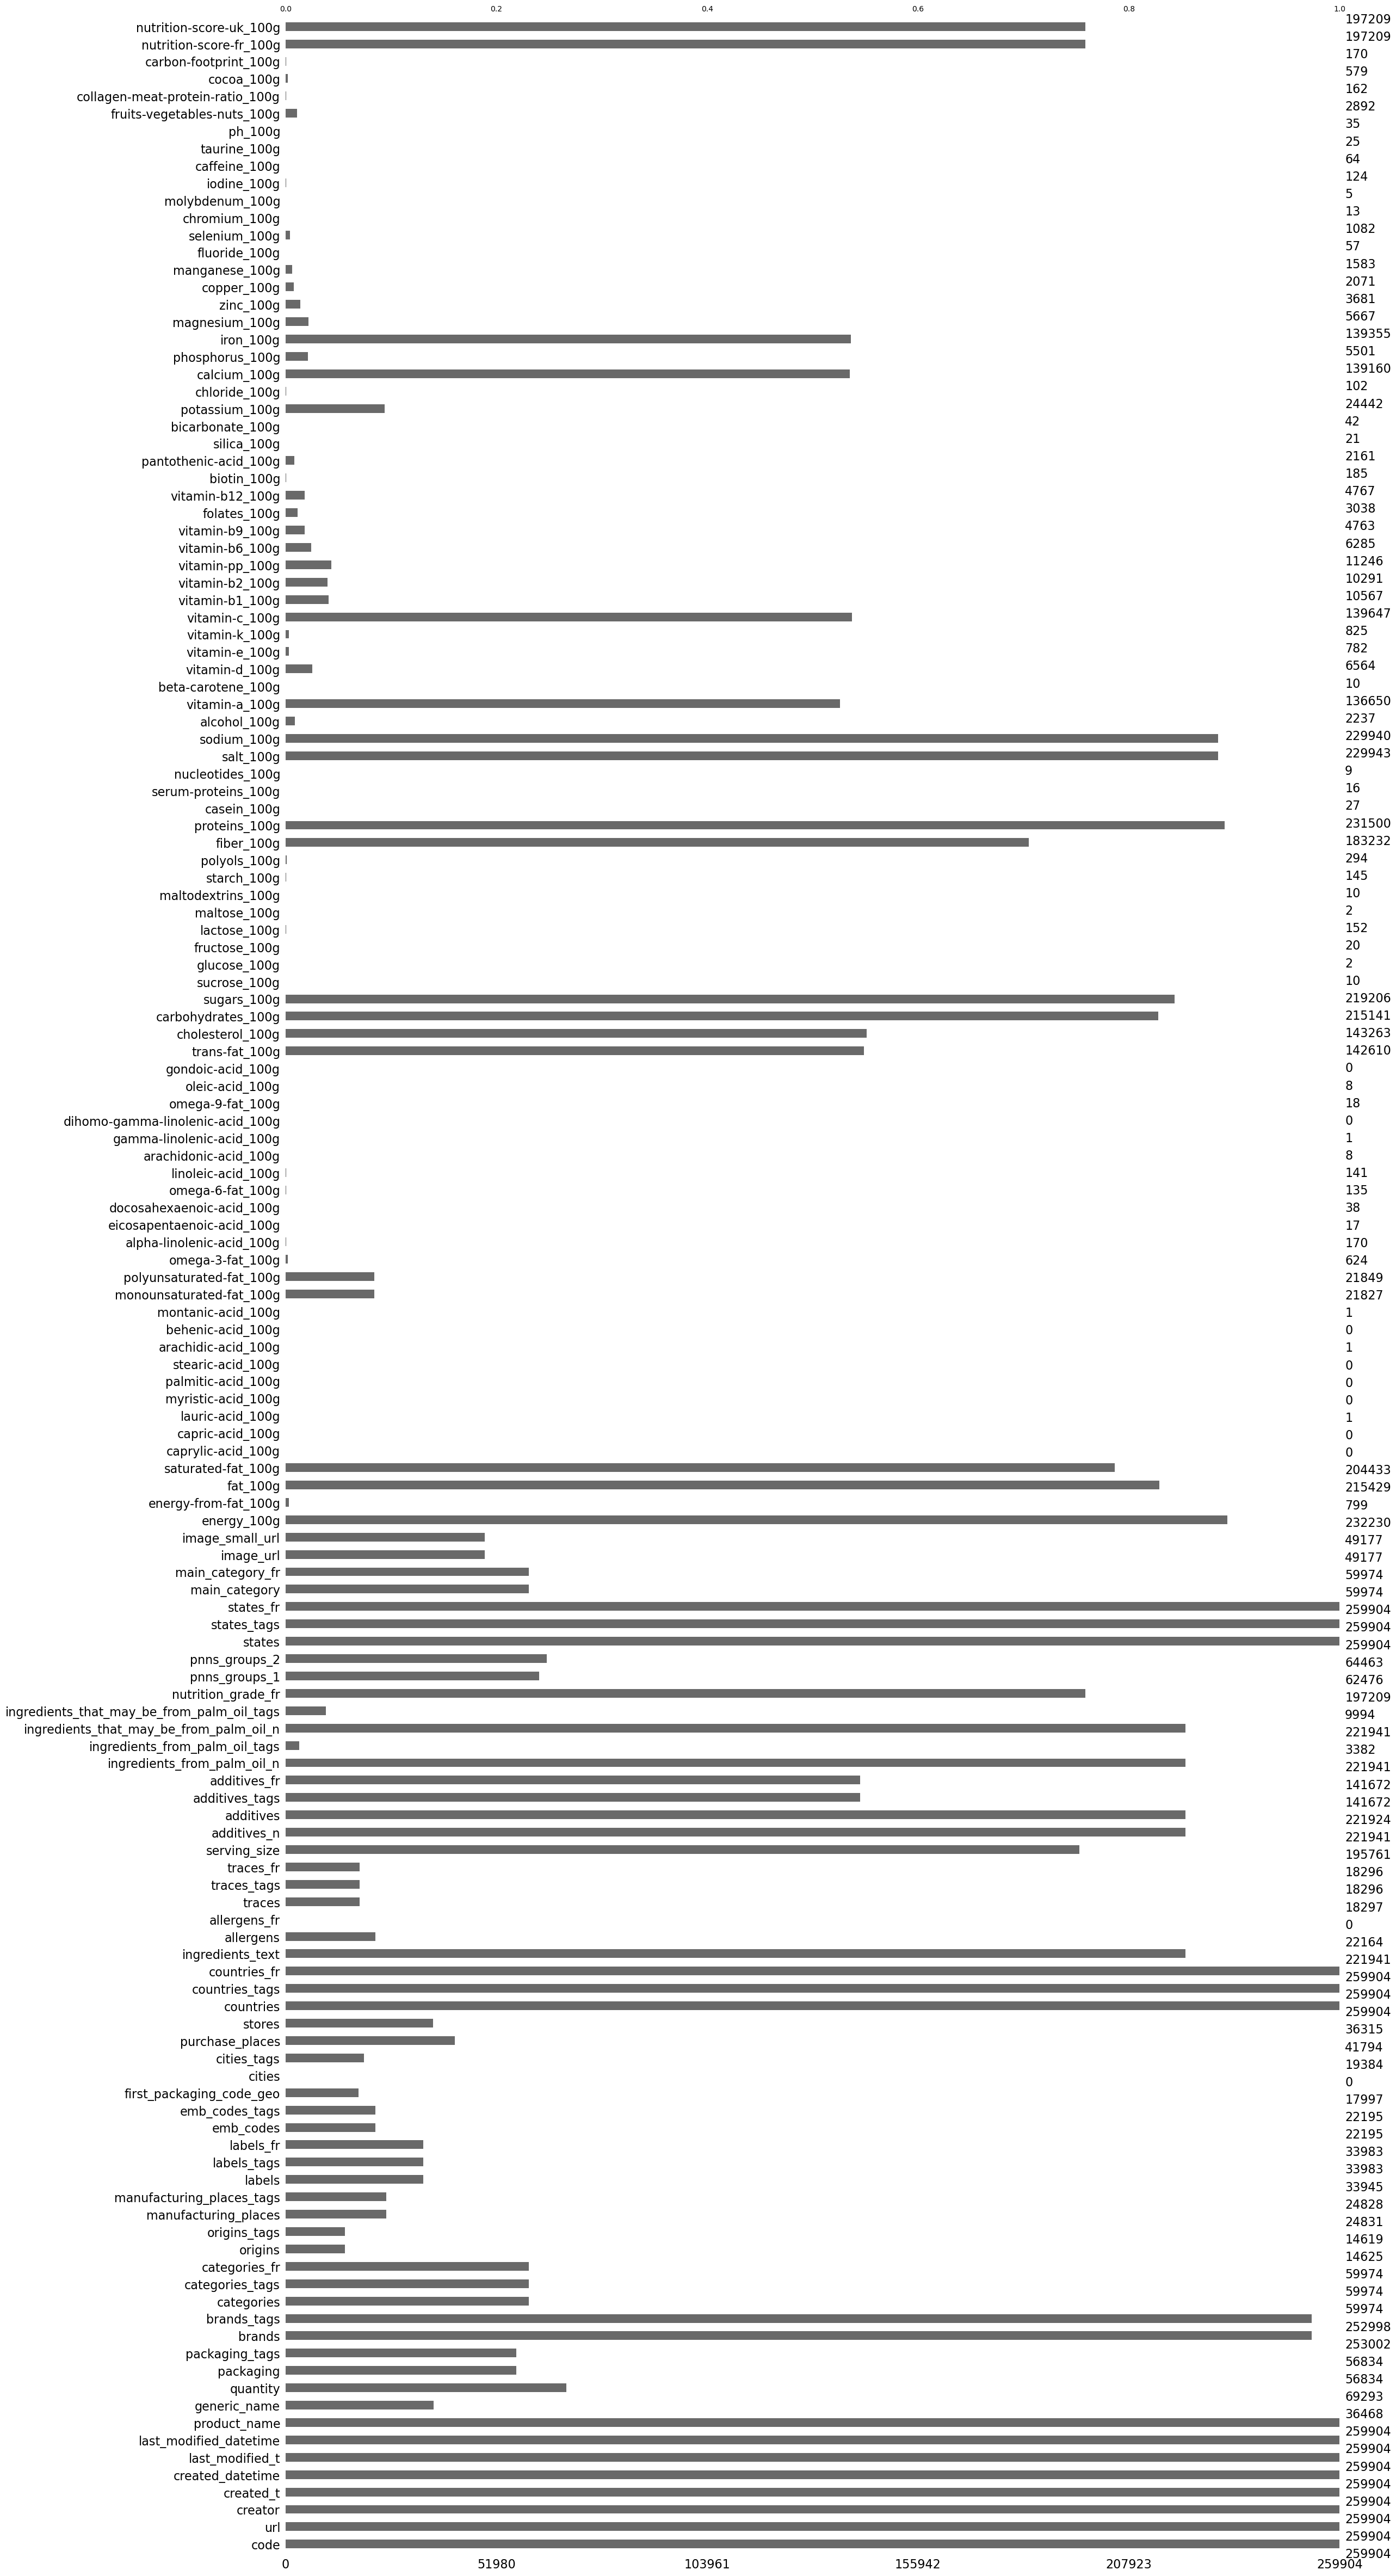

In [6]:
# Vision du taux de remplissage de chaque colonne avec le package 'Missingno'
msno.bar(dataset)

**E. Automatisation de la sélection des colonnes quantitatives à conserver via une boucle conditionnelle avec un seuil de remplissage de 60% minimum**

In [7]:
# Créer une liste pour stocker les noms des colonnes à conserver
quali_features = ['product_name', 'nutrition_grade_fr']

# Suppresion de deux colonnnes
dataset.drop(['nutrition-score-uk_100g', 'nutrition-score-fr_100g'], axis=1, inplace=True)

# Liste des colonnes conservées suite à l'exécution de la boucle for
nutrient_features = []

# Parcourir chaque colonne du dataframe
for nom_colonne in dataset.columns:
    # Vérifier si la colonne est de type numérique
    if dataset[nom_colonne].dtype in ['int64', 'float64']:
        # Calculer le taux de remplissage de la colonne
        taux_remplissage = dataset[nom_colonne].count() / len(dataset) * 100
        # Vérifier si le taux de remplissage est supérieur à 60%
        if taux_remplissage >= 60:
            # Ajouter le nom de la colonne à la liste des colonnes conservées
            nutrient_features.append(nom_colonne)

# Réindexer l'ordre des colonnes
dataset = dataset.reindex(columns = quali_features + nutrient_features)

**F. Filtrer les valeurs pour ne conserver les lignes où nous avons un 'grade nutriscore'**

In [8]:
# Filtrer les lignes du dataframe pour ne garder celles avec une valeur pour le nutriscore
dataset = dataset.dropna(subset=['nutrition_grade_fr'])

**H. Isoler la target du dataframe --> soit la colonne 'nutrition_grade_fr'**

In [9]:
# Création d'une variable 'target' pour isoler la colonne cible
target = dataset['nutrition_grade_fr']

**I. Nombre de doublons puis suppression si présence de doublons**

In [10]:
# Calcul du nombre de doublons dans le dataset à ce niveau de l'étude
duplicated = dataset.duplicated().sum()

# Afficher le nombre de doublons
print("Nombre de doublons :", duplicated)

# Copie du dataset
dataset = dataset.copy()

# Ensuite suppression des doublons
dataset.drop_duplicates(inplace=True)

# Afficher la taille du DataFrame après suppression des doublons
print("Taille du DataFrame après suppression des doublons :", dataset.shape)

Nombre de doublons : 12105
Taille du DataFrame après suppression des doublons : (185104, 14)


**J. Afficher le nom des colonnes conservées et leur type, ainsi que la structure et le taux de remplissage**

In [11]:
# Sortir le nom de chaque colonne du dataframe à titre informatif pour la suite de l'étude
print('Afficher les caractérisques du dataframe :')
print(dataset.dtypes)
print('Taille du fichier', dataset.shape)
print('Taux de remplissage :', round(((dataset.size - dataset.isnull().sum().sum()) / dataset.size)*100, 2),'%')

Afficher les caractérisques du dataframe :
product_name                                object
nutrition_grade_fr                          object
additives_n                                float64
ingredients_from_palm_oil_n                float64
ingredients_that_may_be_from_palm_oil_n    float64
energy_100g                                float64
fat_100g                                   float64
saturated-fat_100g                         float64
carbohydrates_100g                         float64
sugars_100g                                float64
fiber_100g                                 float64
proteins_100g                              float64
salt_100g                                  float64
sodium_100g                                float64
dtype: object
Taille du fichier (185104, 14)
Taux de remplissage : 95.61 %


# III. Nettoyage des valeurs aberrantes & les imputations pour la gestion des données manquantes

**A. Nettoyage des valeurs aberrantes pour les variables quantitatives**

Gestion des valeurs aberrantes pour l'énergie en kcal : si > à 3700kcal --> Suppression de la ligne

In [12]:
# Suppression des lignes où 'energy_100g' est supérieur à 3700
dataset = dataset[dataset['energy_100g'] <= 3700]

Gestion des valeurs aberrantes, non comprises dans l'intervalle [0;100] sauf pour l'énergie

In [13]:
# Boucle itérative pour supprimer les lignes dont les valeurs dépassent 100, sauf pour energy_100g
for index, row in dataset.iterrows():
    if any(row[col] > 100 for col in nutrient_features if col != 'energy_100g'):
        dataset.drop(index, inplace=True)

# Boucle itérative pour supprimer les lignes dont les valeurs sont inférieures à 0
for index, row in dataset.iterrows():
    if any(row[col] <0 for col in nutrient_features if col != 'energy_100g'):
        dataset.drop(index, inplace=True)

Gestion des seuils concernant les valeurs maximum acceptables par nutriment

In [14]:
# Création d'une fonction pour établir et comparer les valeurs selon les seuils pré-définis
def drop_rows_if_above_threshold(dataset, column, threshold):
    dataset.drop(dataset[dataset[column] > threshold].index, inplace=True)

columns_threshold = {
    'proteins_100g': 80,
    'fiber_100g': 45,
}

for column, threshold in columns_threshold.items():
    drop_rows_if_above_threshold(dataset, column, threshold)

Visualisation du taux de remplissage de chaque features du dataframe pour estimer les variables où des imputations sont nécessaires

<Axes: >

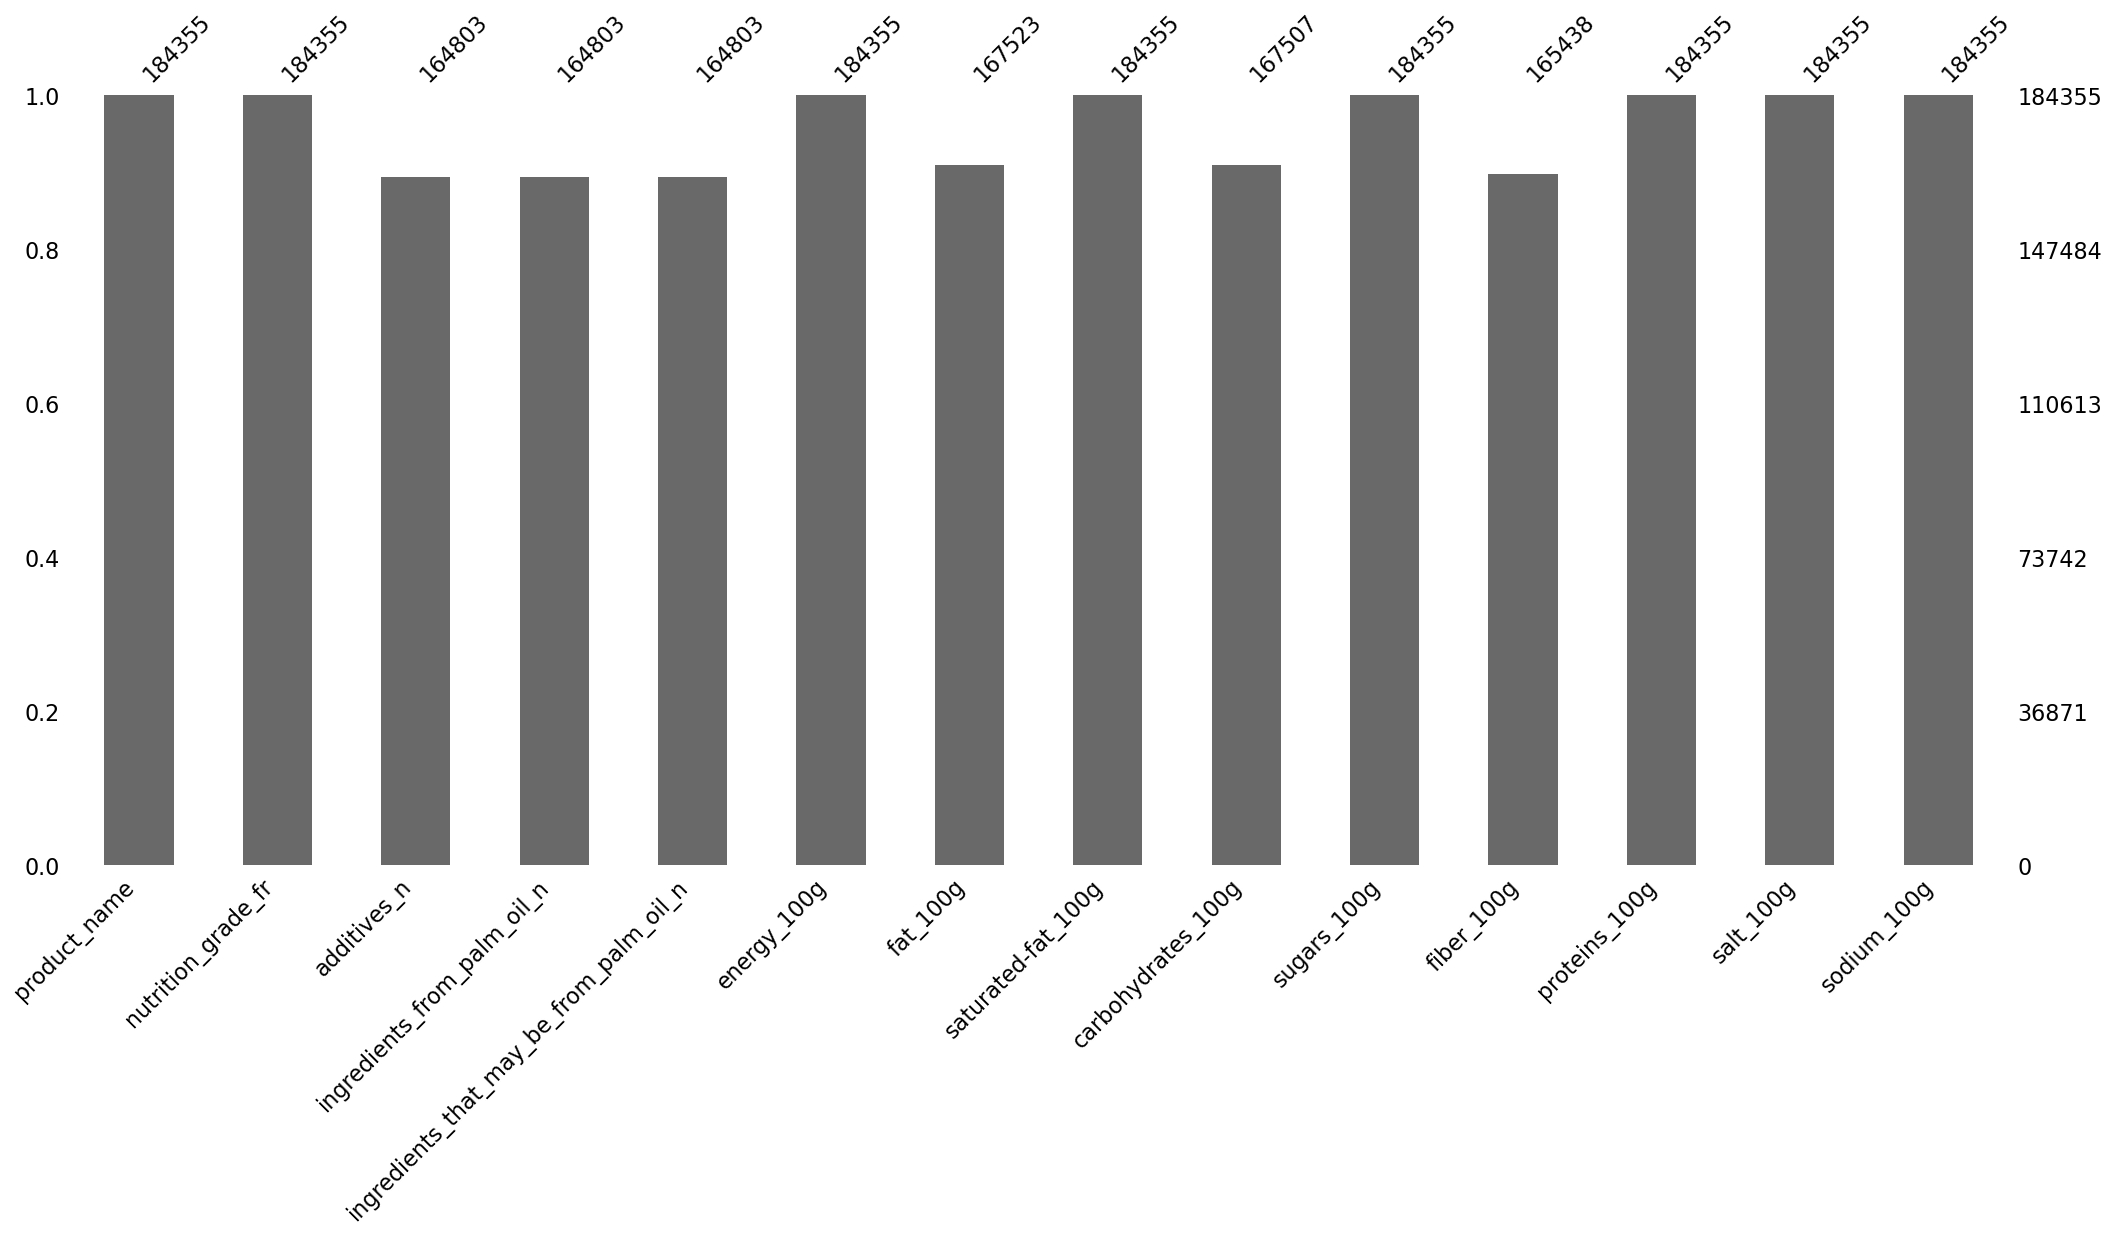

In [15]:
msno.bar(dataset)

Création d'un dataframe dédié pour les imputations pour le rattrapage suite à la soutenance

In [17]:
df_imputation = dataset.copy()

**B. Imputation pour combler les donnnées manquantes du dataframe 'dataset'**

Les colonnes concernées seront par conséquent :

- la teneur en fibre pour 100g --> Imputation des valeurs vides par 0
- le taux de glucides pour 100g --> Imputation des valeurs en utilisant le SimpleImputer, par la moyenne de la colonne
- le nombre d'additifs par produits & huile de palme --> Imputation en supprimant les valeurs vides (correspondance des valeurs vides pour les 3)
- le pourcentage de graisse --> Imputation avec une régression linéaire avec la colonne 'Graisses saturées'

Remplacer par 0 les valeurs vides pour les fibres

In [18]:
# Replacer les vides par 0 pour les fibres
dataset['fiber_100g'].fillna(0, inplace=True)

Remplacer les valeurs vides par la moyenne pour les glucides, en utilisant le SimpleImputer de Sklearn

In [19]:
# Création d'un objet SimpleImputer de sklearn avec la stratégie de l'imputation par la moyenne
imputer = SimpleImputer(strategy='mean')

# Adapter l'imputer aux données avec la fonction fit
imputer.fit(dataset[['carbohydrates_100g']])

# Imputer les valeurs manquantes dans la colonne 'carbohydrates_100g' du dataset
dataset['carbohydrates_100g'] = imputer.transform(dataset[['carbohydrates_100g']])

Imputation des données manquantes pour les graisses, avec une régression linéaire

In [20]:
# Calcul du coefficient de corrélation entre la variable 'fat_100g' & 'saturated-fat_100g'
x = dataset['fat_100g']
y = dataset['saturated-fat_100g']

# Calcul du coefficient de corrélation
coef_corr = x.corr(y)

# Moyenne avant la régression linéaire
mean_before_reg = dataset['fat_100g'].mean().round(2)

print("Coefficient de corrélation de Pearson :", round((coef_corr),4))
print("Moyenne avant la régression linéaire", mean_before_reg)

Coefficient de corrélation de Pearson : 0.7089
Moyenne avant la régression linéaire 13.15


Utilisation du module de sklearn 'LinearRegression'

In [21]:
# Séparer les données en ensembles avec et sans valeurs manquantes pour la colonne 'fat_100g'
data_with_missing = dataset[dataset['fat_100g'].isnull()]
data_without_missing = dataset.dropna(subset=['fat_100g'])

# Diviser les données non manquantes en X et Y
X_train = data_without_missing[['saturated-fat_100g']]
y_train = data_without_missing['fat_100g']

# Créer et entraîner le modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Utiliser le modèle pour prédire les valeurs manquantes dans 'fat_100g'
predicted_values = model.predict(data_with_missing[['saturated-fat_100g']])

# Filtrer les valeurs prédites qui dépassent 100
predicted_values = np.clip(predicted_values, None, 100)

# Remplacer les valeurs manquantes par les valeurs prédites
dataset.loc[dataset['fat_100g'].isnull(), 'fat_100g'] = predicted_values

# Moyenne après régression linéaire
mean_after_reg = dataset['fat_100g'].mean().round(2)

# Vérifier que toutes les valeurs manquantes ont été imputées
print("Nombre de valeurs manquantes après imputation de la colonne fat_100g:", dataset['fat_100g'].isnull().sum())
print("Moyenne avant la régression linéaire", mean_after_reg)

Nombre de valeurs manquantes après imputation de la colonne fat_100g: 0
Moyenne avant la régression linéaire 13.24


Suppression des lignes vides pour les additifs ainsi que les produits avec de l'huile de palme : nous remarquons que les valeurs nulles sont pour les 3 variables sur les mêmes produits, cela limite la perte d'information.

In [22]:
dataset = dataset.dropna(subset=['additives_n'])

# IV. Consolidation du dataframe nettoyé & préparé pour analyse

In [23]:
# Consolidation du dataframe nettoyé et exhaustif
clear_dataset = dataset.copy()

# Création d'une variable 'target' pour isoler la colonne cible
cible = clear_dataset['nutrition_grade_fr']

# Pour créer un fichier CSV à partir de clear_dataset
#clear_dataset.to_csv('clear_dataset.csv', index=False)

In [24]:
# Sortir le nom de chaque colonne du dataframe à titre informatif pour la suite de l'étude
print('Afficher les caractérisques du dataframe :')
print(clear_dataset.dtypes)
print('Taille du fichier', clear_dataset.shape)
print('Taux de remplissage :', round(((clear_dataset.size - clear_dataset.isnull().sum().sum()) / clear_dataset.size)*100, 2),'%')

Afficher les caractérisques du dataframe :
product_name                                object
nutrition_grade_fr                          object
additives_n                                float64
ingredients_from_palm_oil_n                float64
ingredients_that_may_be_from_palm_oil_n    float64
energy_100g                                float64
fat_100g                                   float64
saturated-fat_100g                         float64
carbohydrates_100g                         float64
sugars_100g                                float64
fiber_100g                                 float64
proteins_100g                              float64
salt_100g                                  float64
sodium_100g                                float64
dtype: object
Taille du fichier (164803, 14)
Taux de remplissage : 100.0 %


# V. Analyse univariée de chaque variable quantitative : Boxplot & Distribution de chacune des variables

Description globale de chacune des variables avec la fonction 'describe'

In [23]:
clear_dataset.describe().round(2)

additives_n  ingredients_from_palm_oil_n  \
count    164803.00                    164803.00   
mean          2.07                         0.02   
std           2.58                         0.13   
min           0.00                         0.00   
25%           0.00                         0.00   
50%           1.00                         0.00   
75%           3.00                         0.00   
max          31.00                         2.00   

       ingredients_that_may_be_from_palm_oil_n  energy_100g   fat_100g  \
count                                164803.00    164803.00  164803.00   
mean                                      0.06      1182.16      13.13   
std                                       0.27       738.94      15.35   
min                                       0.00         0.00       0.00   
25%                                       0.00       481.00       0.90   
50%                                       0.00      1197.00       7.41   
75%                                       0.00      1715.00      21.43   
max                                       5.00      3700.00     100.00   

       saturated-fat_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
count           164803.00           164803.00    164803.00   164803.00   
mean                 4.78               34.02        15.24        2.50   
std                  7.03               28.27        19.82        3.97   
min                  0.00                0.00         0.00        0.00   
25%                  0.00                7.34         1.33        0.00   
50%                  1.79               26.00         5.36        1.10   
75%                  7.08               60.00        23.70        3.50   
max                100.00              100.00       100.00       45.00   

       proteins_100g  salt_100g  sodium_100g  
count      164803.00  164803.00    164803.00  
mean            7.82       1.28         0.50  
std             7.95       3.89         1.53  
min             0.00       0.00         0.00  
25%             2.10       0.12         0.05  
50%             5.71       0.71         0.28  
75%            10.87       1.42         0.56  
max            80.00     100.00        39.37

**A. Visualisation des données à travers une boîte à moustache**

Boxplot pour les nutriments par 100g

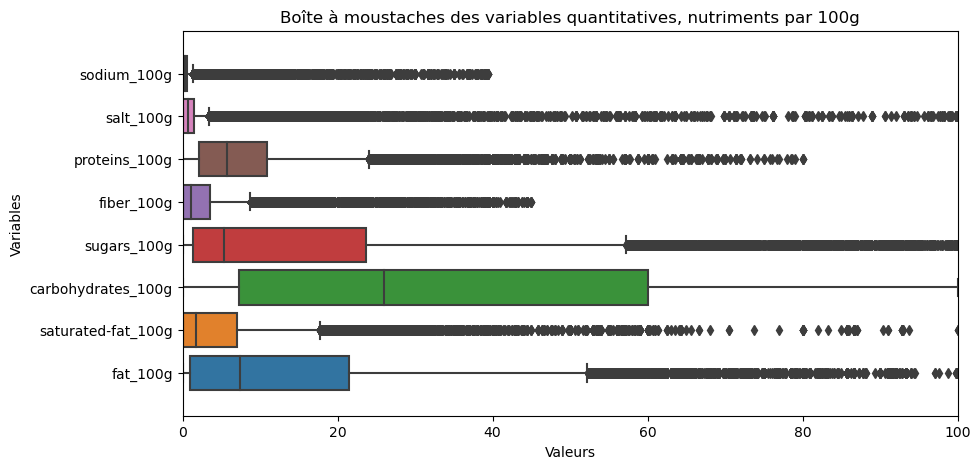

In [24]:
# Exclure la variable 'energy_100g','energy_100g', 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n'
columns_to_exclude = ['energy_100g', 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n']
df_without_energy = clear_dataset.drop(columns=columns_to_exclude)

# Taille du graphique
plt.figure(figsize=(10, 5))

# Tracer les boîtes à moustache
sns.boxplot(data=df_without_energy, orient='h')

# Modifier les limites des axes
plt.xlim(0, 100)
plt.ylim(-1, 8)

plt.title('Boîte à moustaches des variables quantitatives, nutriments par 100g')
plt.xlabel('Valeurs')
plt.ylabel('Variables')
plt.show()

Boxplot pour les addififs et produits avec de l'huile de palme

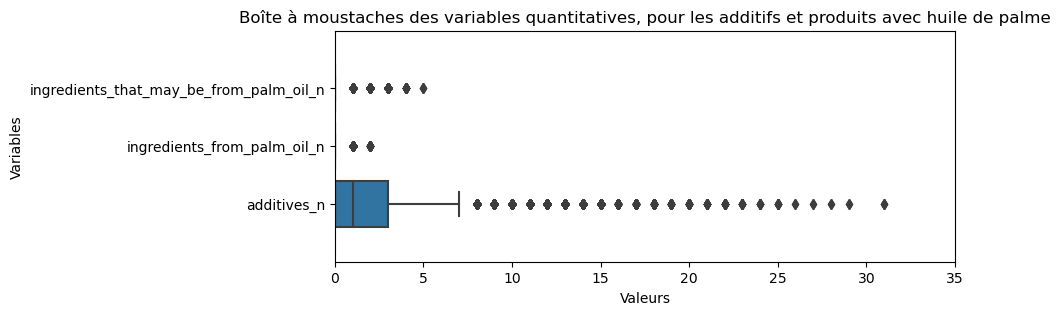

In [25]:
# Exclure les nutriments par 100g
columns_to_exclude_bis = ['energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g']
df_without_100g = clear_dataset.drop(columns=columns_to_exclude_bis)

# Taille du graphique
plt.figure(figsize=(8, 3))

# Tracer les boîtes à moustache
sns.boxplot(data=df_without_100g, orient='h')

# Modifier les limites des axes
plt.xlim(0, 35)
plt.ylim(-1, 3)

plt.title('Boîte à moustaches des variables quantitatives, pour les additifs et produits avec huile de palme')
plt.xlabel('Valeurs')
plt.ylabel('Variables')
plt.show()

Boxplot pour l'énergie en kCal pour 100g

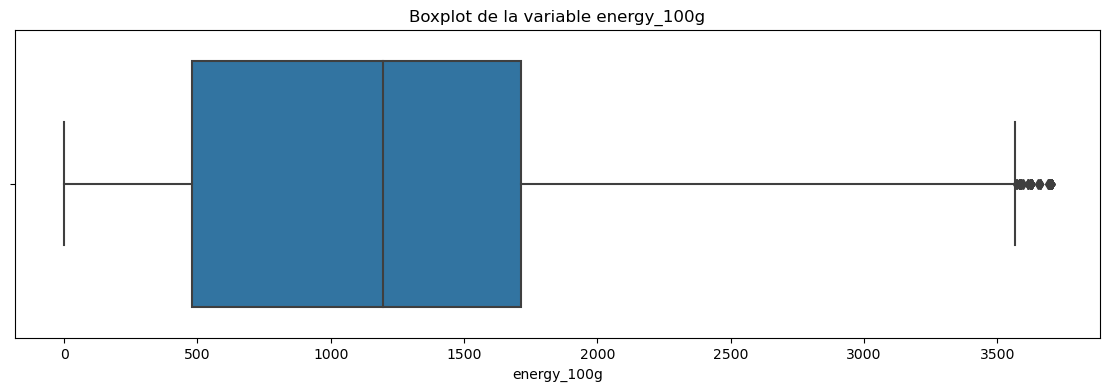

In [26]:
# Ajuster la taille du boxplot
plt.figure(figsize=(14,4))

# Création du graphique
sns.boxplot(x='energy_100g', data=clear_dataset, orient='h')
plt.title('Boxplot de la variable energy_100g')
plt.xlabel('energy_100g')
plt.show()

On dénombre beaucoup d'outliers, quand on regarde le boxplot ci-dessus. L'explication se trouve dans le nombre important de produit, ainsi que beaucoup de valeurs atypiques, comme pour le sel, le sucre ou l'huile. Ce sont des produits qui expliquent des valeurs se rapprochant de 100g pour certaines variables.

**B. Visualisation de la distribution de chaque variable quantitative**

La distribution de chacune des variables quantitatives

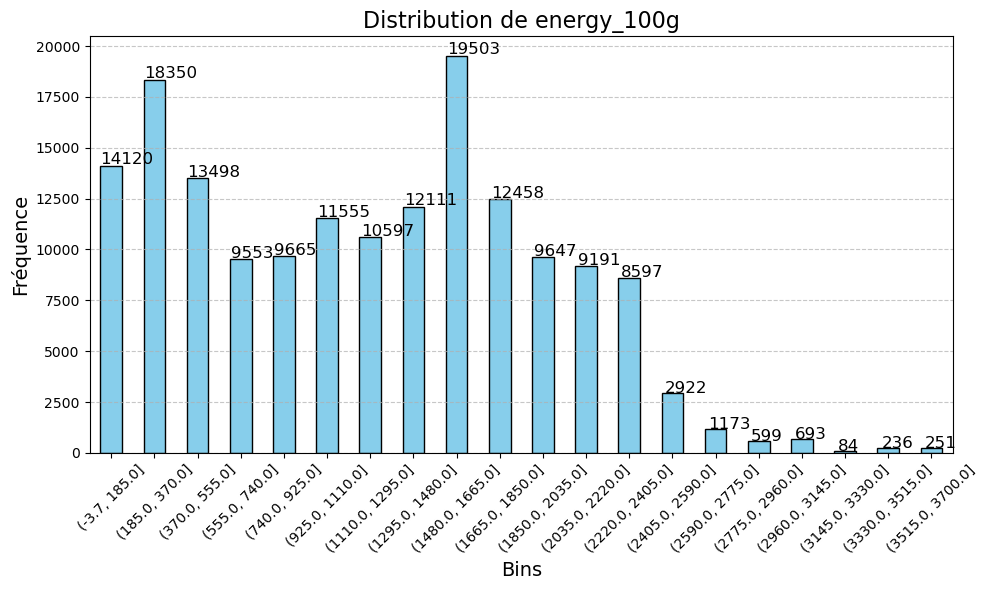

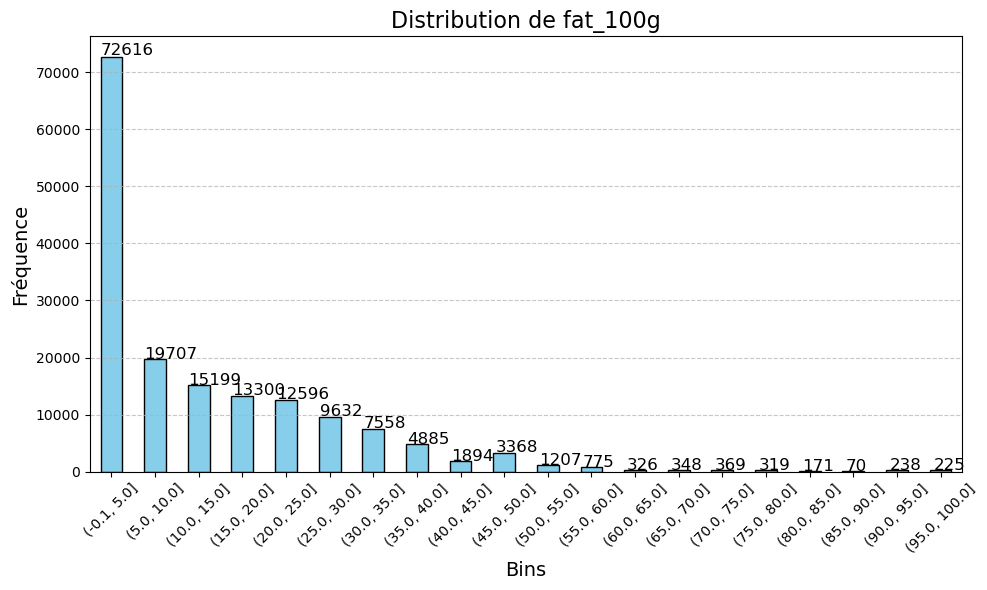

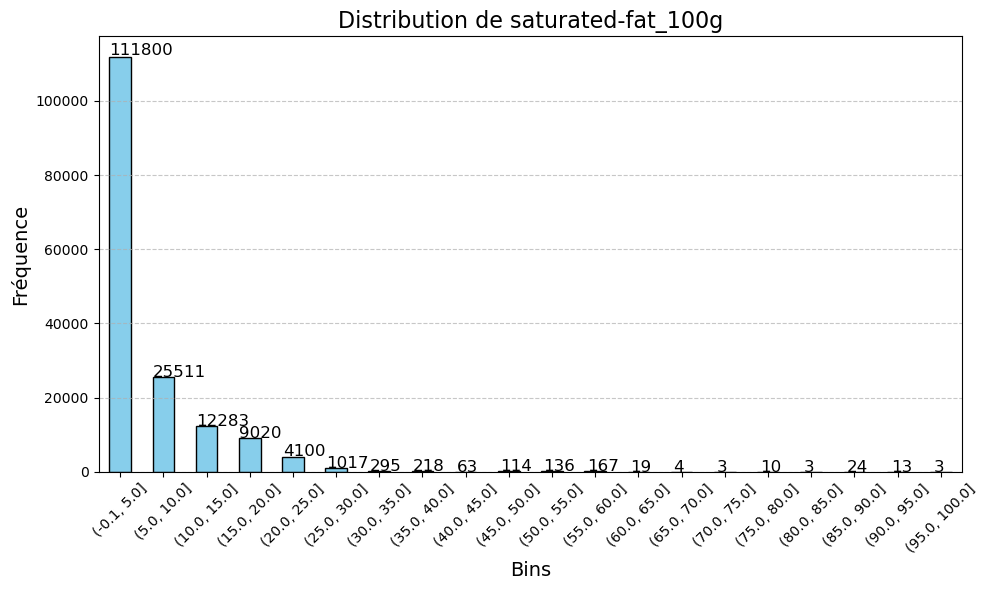

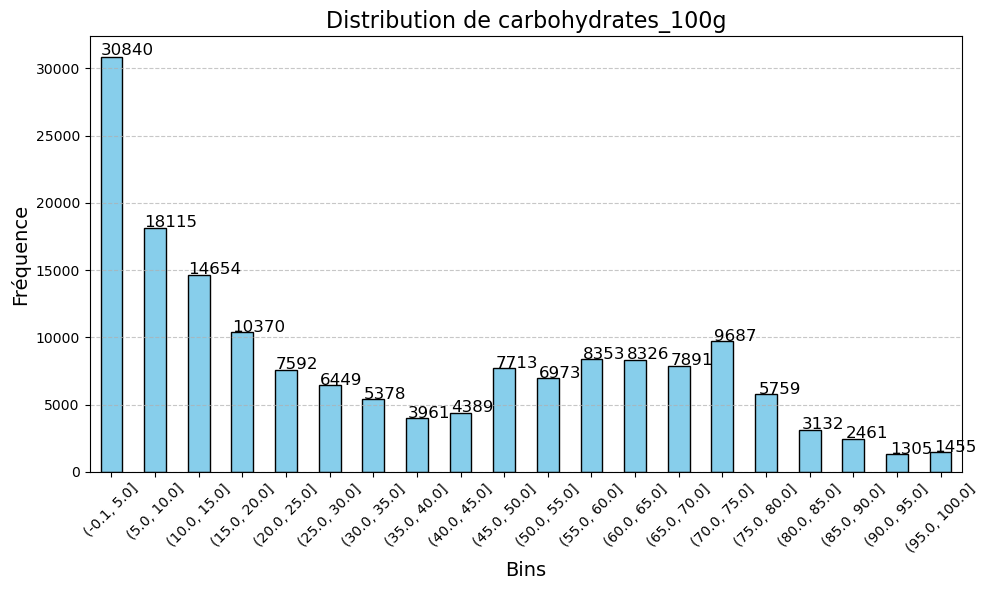

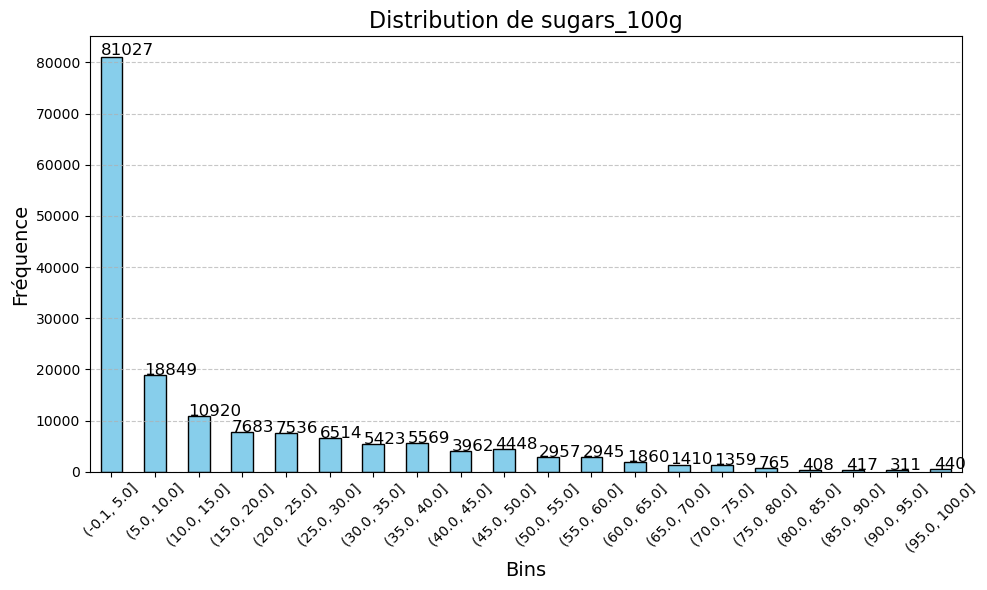

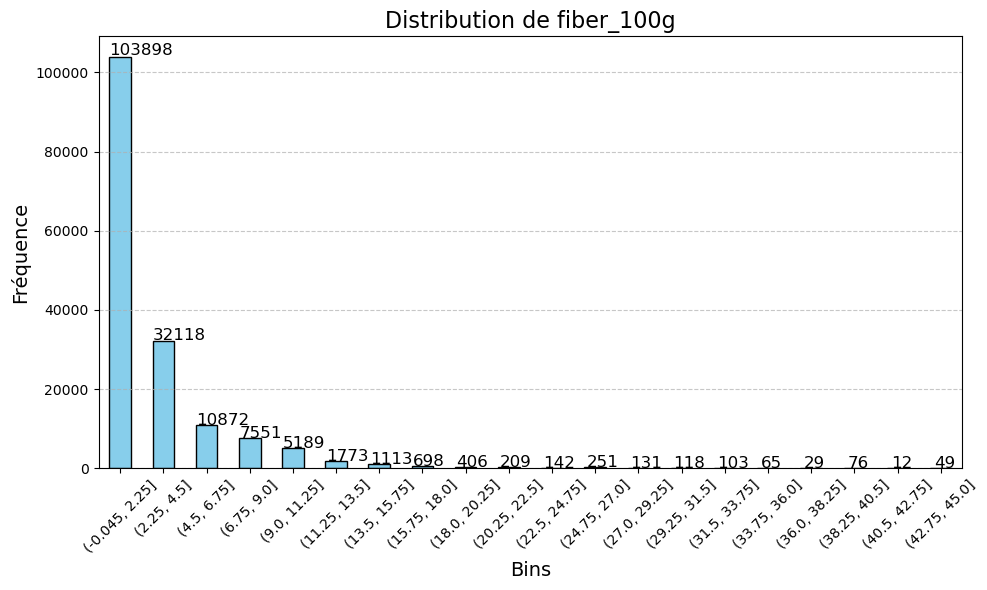

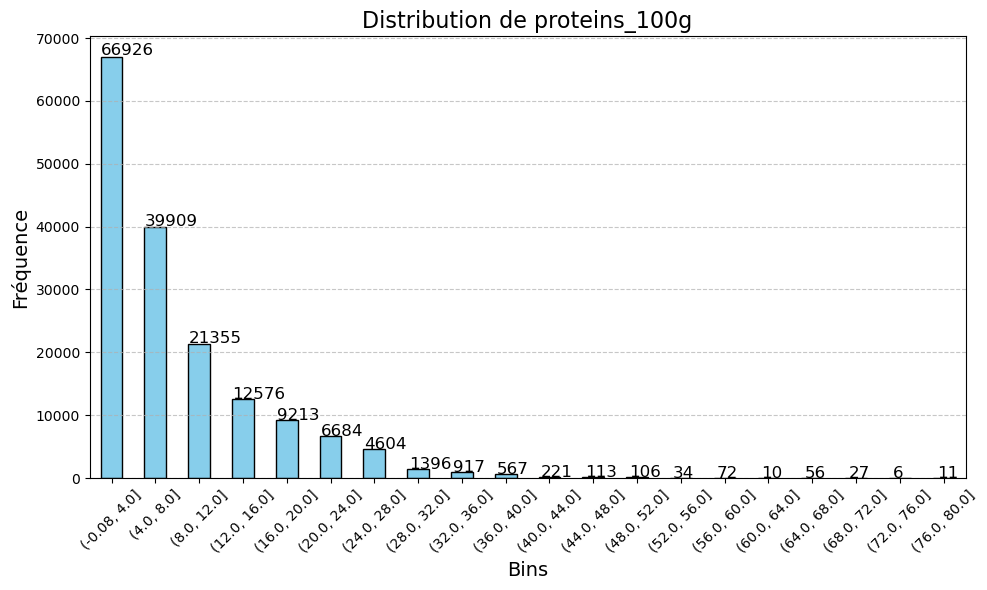

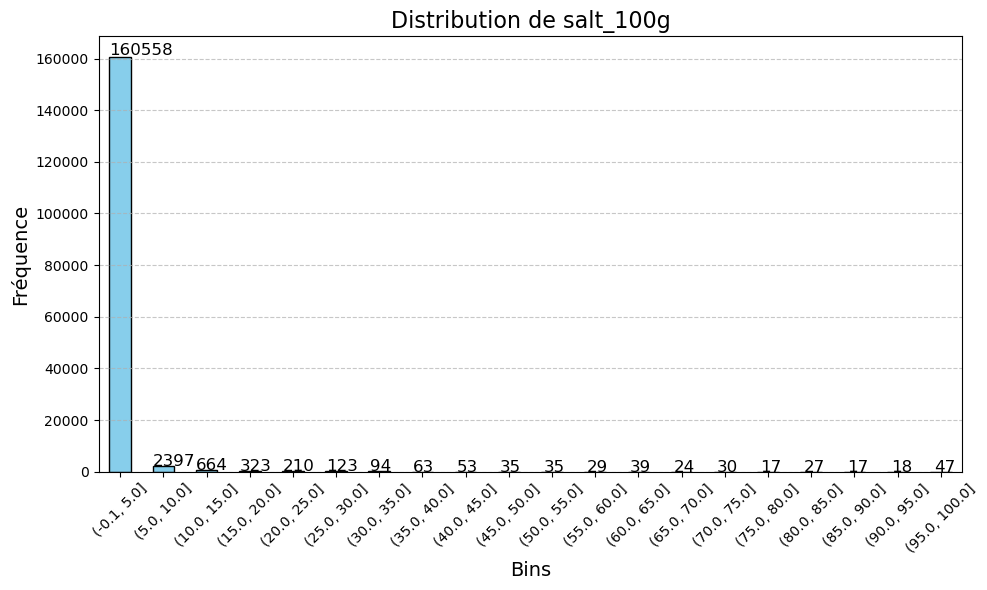

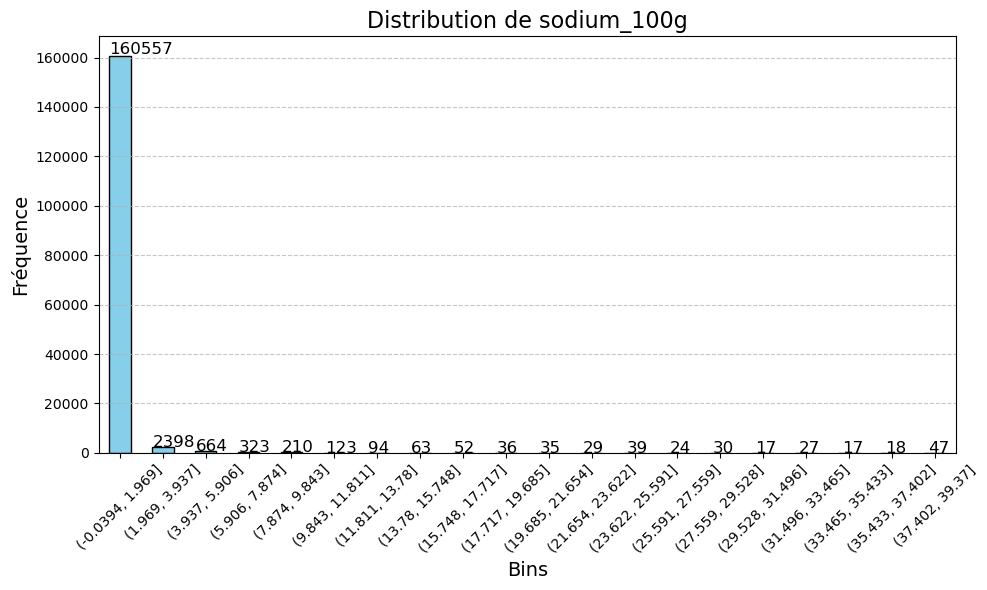

In [27]:
# Nouvelle liste avec les éléments contenant '100g' dans le nom
nutrient_100g = [nutrient for nutrient in nutrient_features if '100g' in nutrient]

# Création d'un nouveau dataframe pour effectuer la graphique avec la discrétisation
dataset_disc = clear_dataset.copy()

# Discrétisation des valeurs en 20 catégories et plot des histogrammes
for nutrient in nutrient_100g:
    dataset_disc[nutrient + '_disc'] = pd.cut(dataset_disc[nutrient], bins=20)
    
    plt.figure(figsize=(10, 6))
    ax = dataset_disc[nutrient + '_disc'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
    ax.set_title('Distribution de ' + nutrient, fontsize=16)
    ax.set_xlabel('Bins', fontsize=14)
    ax.set_ylabel('Fréquence', fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=12)
    
    plt.tight_layout()
    plt.show()

Visualisation des produits selon leur grade

Un histogramme :

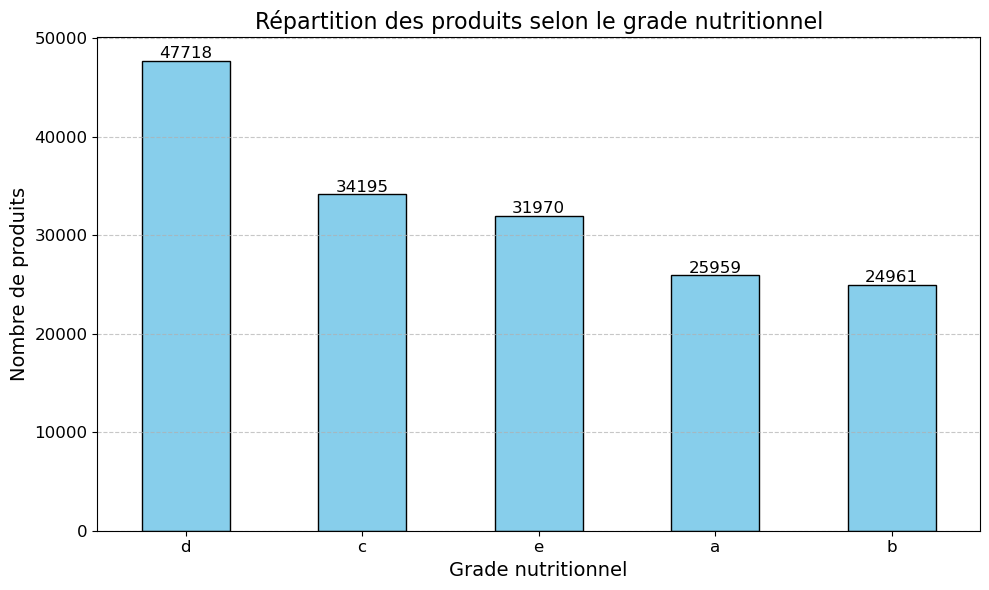

In [28]:
# Compter le nombre d'occurrences de chaque grade nutritionnel
nutrition_counts = dataset['nutrition_grade_fr'].value_counts()

# Créer un diagramme à barres avec des étiquettes de valeurs
plt.figure(figsize=(10, 6))
bars = nutrition_counts.plot(kind='bar', color='skyblue', edgecolor='black')  
plt.title('Répartition des produits selon le grade nutritionnel', fontsize=16)
plt.xlabel('Grade nutritionnel', fontsize=14)
plt.ylabel('Nombre de produits', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajouter des étiquettes de valeurs au-dessus de chaque barre
for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.0f'),
                 (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha='center', va='center',
                 xytext=(0, 5), textcoords='offset points', fontsize=12)

plt.tight_layout()
plt.show()

Un diagramme circulaire :

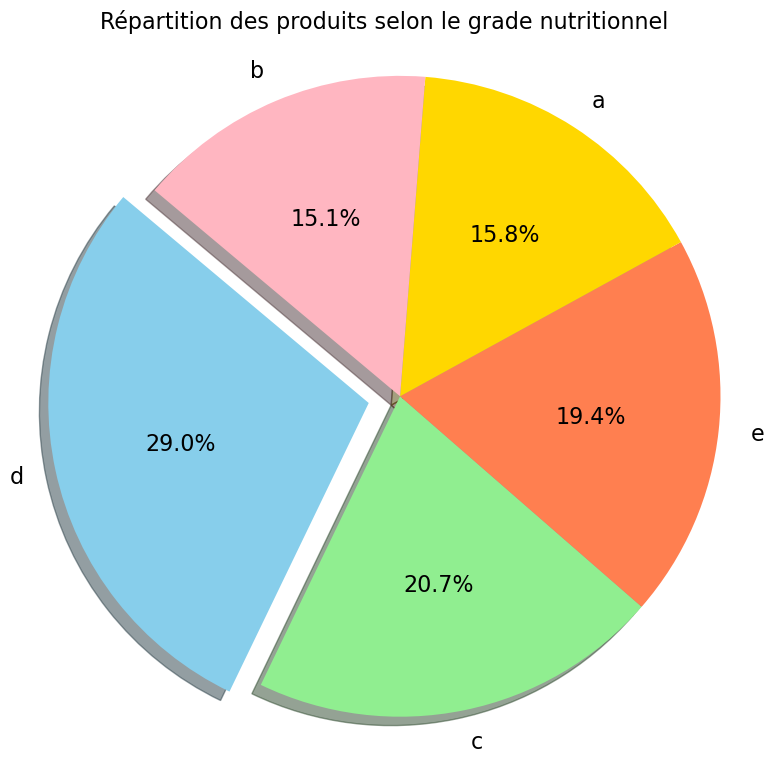

In [29]:
# Compter le nombre d'occurrences de chaque grade nutritionnel
nutrition_counts = dataset['nutrition_grade_fr'].value_counts()

# Définir une taille de police plus grande
plt.rcParams.update({'font.size': 16})

# Créer un diagramme circulaire
plt.figure(figsize=(8, 8))
colors = ['skyblue', 'lightgreen', 'coral', 'gold', 'lightpink']
explode = (0.1, 0, 0, 0, 0)  # Faire ressortir la première tranche
plt.pie(nutrition_counts, labels=nutrition_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, shadow=True)
plt.title('Répartition des produits selon le grade nutritionnel', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

# VI. Analyse bivariée avec Seaborn


**1. Création d'une heatmap pour visualiser les différents points de corrélation entre les features**

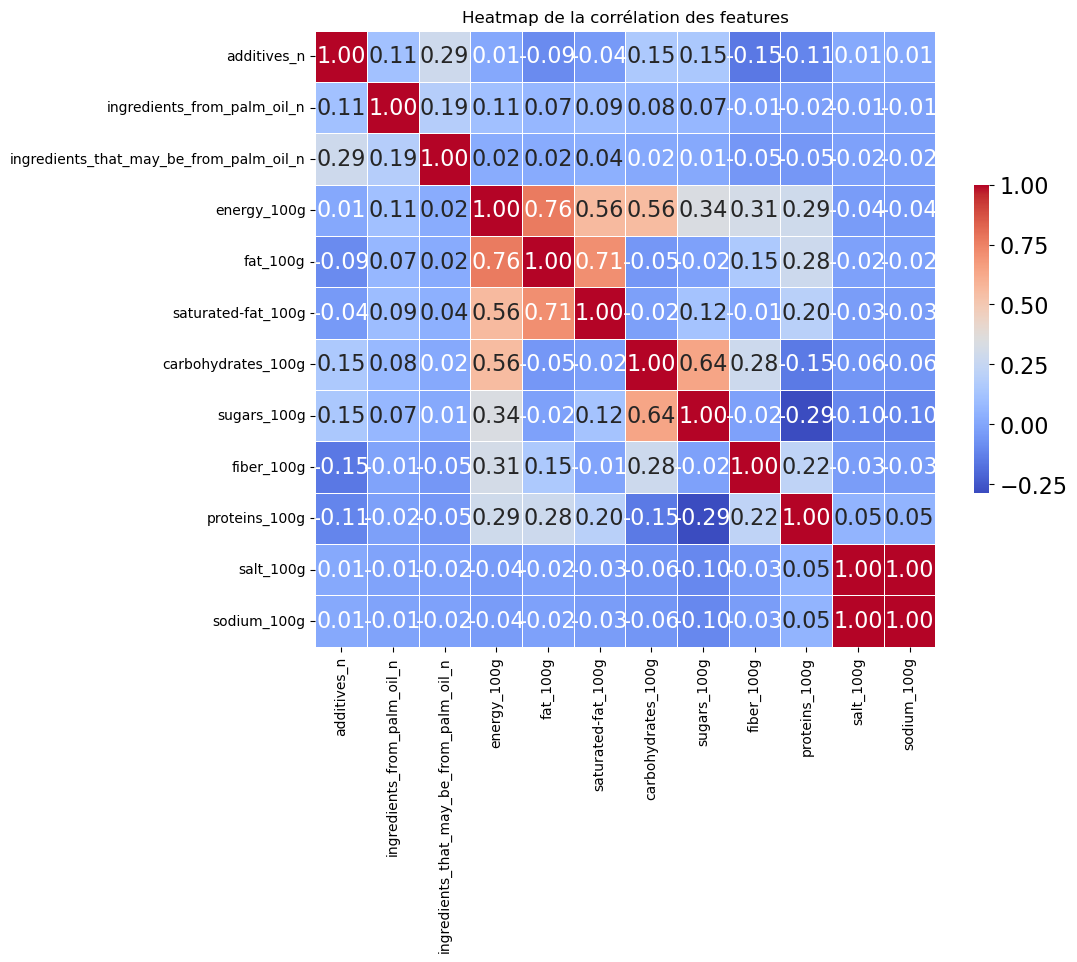

In [31]:
# Sélection des colonnes de type float
float_columns = dataset.select_dtypes(include=['float']).columns

# Création de la table de corrélation pour ces colonnes
correlation_matrix = dataset[float_columns].corr()

# Création de la heatmap avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap de la corrélation des features', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.show()

**2. Visualisation de paires de features grâce au scatter de Seaborn**

Relation entre les graisses et les graisses saturées

C:\Users\justi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


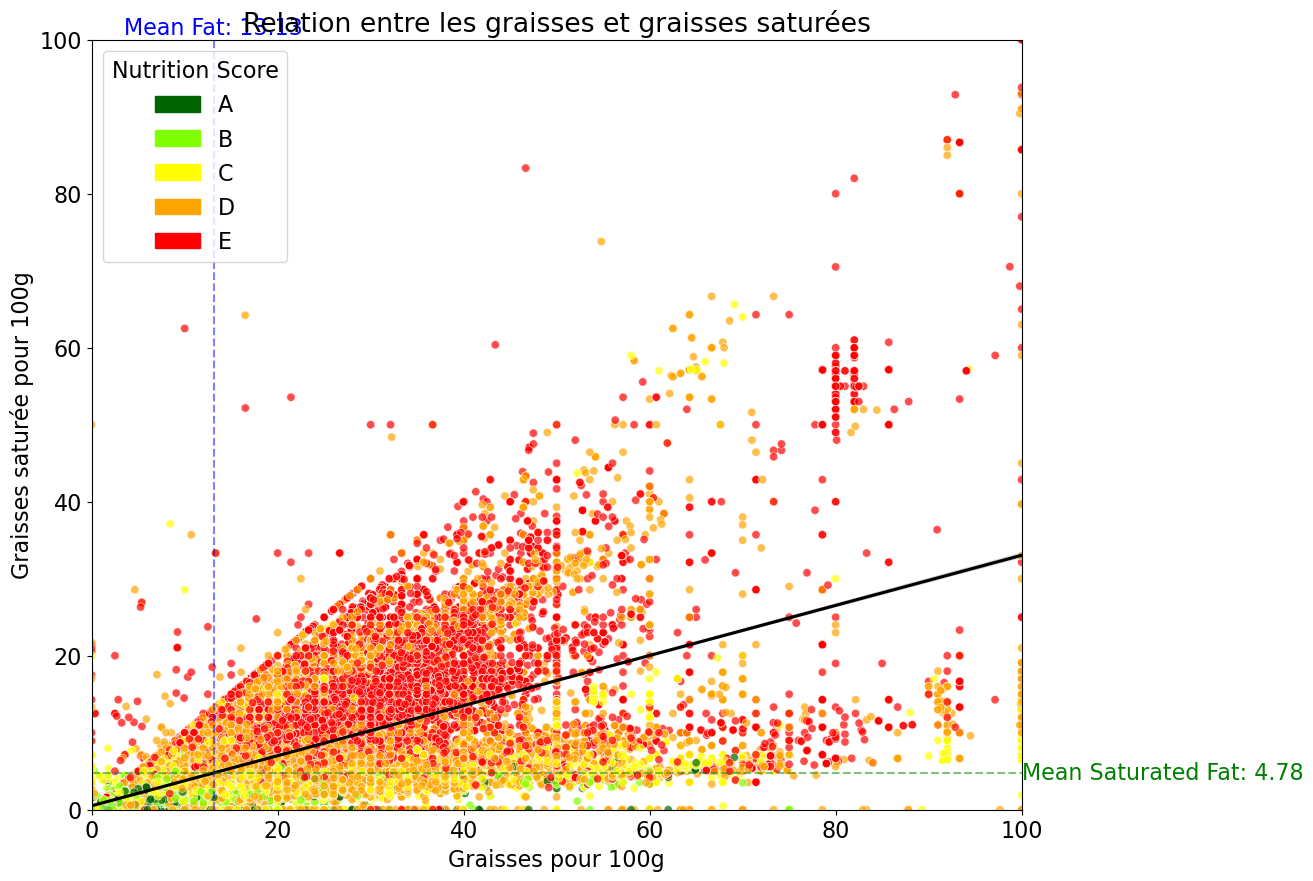

In [33]:
# Création d'une légende personnalisée avec les couleurs correctes pour chaque grade nutritionnel
legend_handles = [
    mpatches.Patch(color='#006400', label='A'),
    mpatches.Patch(color='#7FFF00', label='B'),
    mpatches.Patch(color='yellow', label='C'),
    mpatches.Patch(color='orange', label='D'),
    mpatches.Patch(color='red', label='E')
]

# Définir une palette de couleurs personnalisée pour chaque grade nutritionnel
custom_palette = {'a': '#006400',  # Vert foncé
                  'b': '#7FFF00',  # Vert clair
                  'c': 'yellow',   # Jaune
                  'd': 'orange',   # Orange
                  'e': 'red'}      # Rouge

# Créer le graphique avec les ajustements
plt.figure(figsize=(12, 10))
sns.scatterplot(x="fat_100g", y="saturated-fat_100g", hue="nutrition_grade_fr", data=clear_dataset, 
                palette=custom_palette, alpha=0.7)

# Ajouter une ligne de régression linéaire
sns.regplot(x="fat_100g", y="saturated-fat_100g", data=clear_dataset, scatter=False, color='black')

# Modifier les limites des axes et ajouter des titres
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel("Graisses pour 100g")
plt.ylabel("Graisses saturée pour 100g")
plt.title("Relation entre les graisses et graisses saturées")

# Ajouter la légende personnalisée
plt.legend(handles=legend_handles, title="Nutrition Score")

# Calculer les moyennes des graisses et des graisses saturées
mean_fat = clear_dataset['fat_100g'].mean()
mean_saturated_fat = clear_dataset['saturated-fat_100g'].mean()

# Ajouter les moyennes au graphique
plt.text(mean_fat, plt.ylim()[1], f"Mean Fat: {mean_fat:.2f}", va='bottom', ha='center', color='blue')
plt.text(plt.xlim()[1], mean_saturated_fat, f"Mean Saturated Fat: {mean_saturated_fat:.2f}", va='center', ha='left', color='green')

# Tracer les courbes de régression avec les moyennes
plt.plot([mean_fat, mean_fat], plt.ylim(), linestyle='--', color='blue', alpha=0.5)
plt.plot(plt.xlim(), [mean_saturated_fat, mean_saturated_fat], linestyle='--', color='green', alpha=0.5)

plt.show()

Relation entre l'énergie et la teneur en sucre des produits

C:\Users\justi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


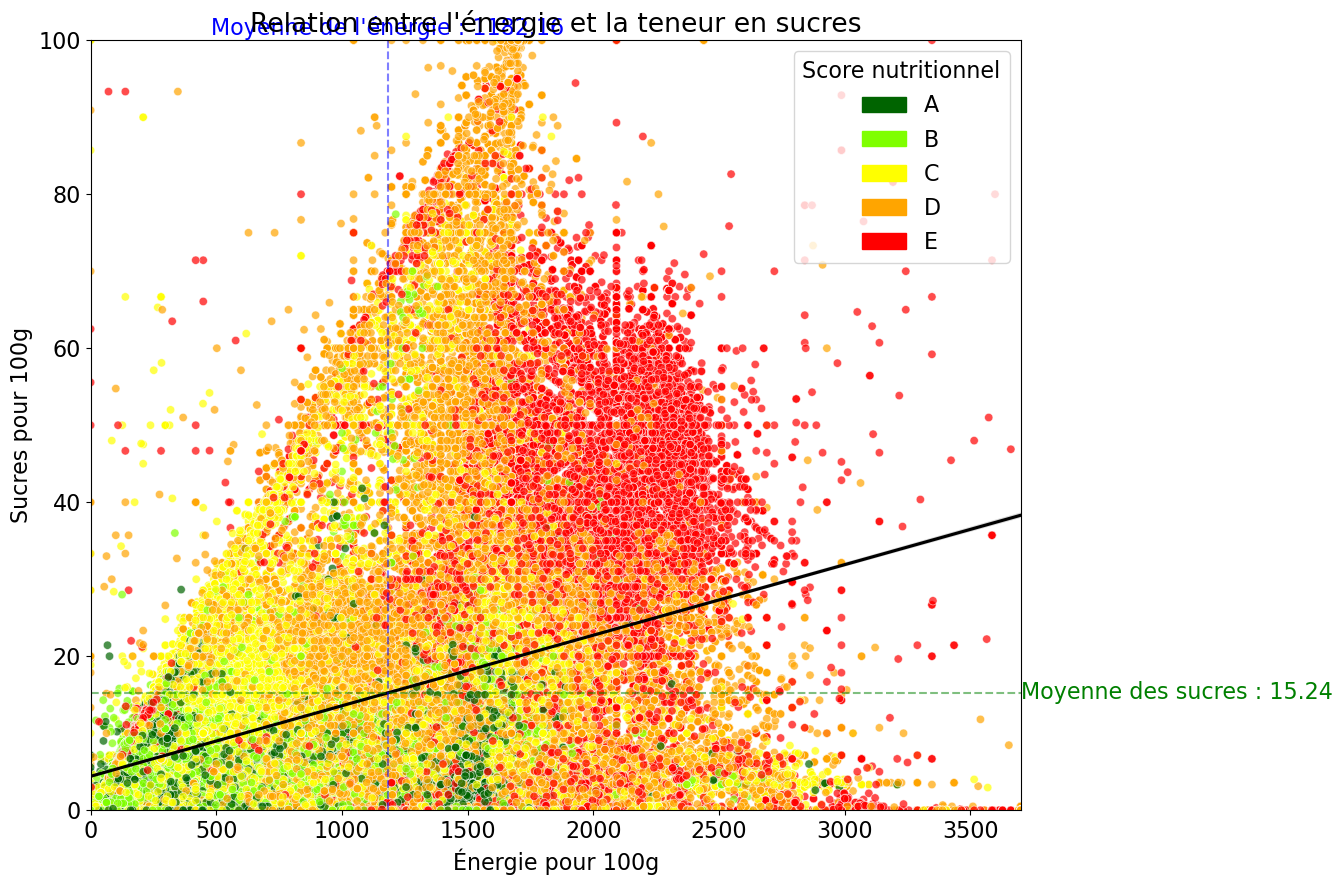

In [34]:
# Création d'une légende personnalisée avec les couleurs correctes pour chaque grade nutritionnel
legend_handles = [
    mpatches.Patch(color='#006400', label='A'),
    mpatches.Patch(color='#7FFF00', label='B'),
    mpatches.Patch(color='yellow', label='C'),
    mpatches.Patch(color='orange', label='D'),
    mpatches.Patch(color='red', label='E')
]

# Définir une palette de couleurs personnalisée pour chaque grade nutritionnel
custom_palette = {'a': '#006400',  # Vert foncé
                  'b': '#7FFF00',  # Vert clair
                  'c': 'yellow',   # Jaune
                  'd': 'orange',   # Orange
                  'e': 'red'}      # Rouge

# Créer le graphique avec les ajustements
plt.figure(figsize=(12, 10))
sns.scatterplot(x="energy_100g", y="sugars_100g", hue="nutrition_grade_fr", data=clear_dataset, 
                palette=custom_palette, alpha=0.7)

# Ajouter une ligne de régression linéaire
sns.regplot(x="energy_100g", y="sugars_100g", data=clear_dataset, scatter=False, color='black')

# Modifier les limites des axes et ajouter des titres
plt.xlim(0, 3700)
plt.ylim(0, 100)
plt.xlabel("Énergie pour 100g")
plt.ylabel("Sucres pour 100g")
plt.title("Relation entre l'énergie et la teneur en sucres")

# Ajouter la légende personnalisée
plt.legend(handles=legend_handles, title="Score nutritionnel")

# Calculer les moyennes des sucres et de l'énergie
mean_energy = clear_dataset['energy_100g'].mean()
mean_sugars = clear_dataset['sugars_100g'].mean()

# Ajouter les moyennes au graphique
plt.text(mean_energy, plt.ylim()[1], f"Moyenne de l'énergie : {mean_energy:.2f}", va='bottom', ha='center', color='blue')
plt.text(plt.xlim()[1], mean_sugars, f"Moyenne des sucres : {mean_sugars:.2f}", va='center', ha='left', color='green')

# Tracer les courbes de régression avec les moyennes
plt.plot([mean_energy, mean_energy], plt.ylim(), linestyle='--', color='blue', alpha=0.5)
plt.plot(plt.xlim(), [mean_sugars, mean_sugars], linestyle='--', color='green', alpha=0.5)

plt.show()

Relation entre l'énergie et la teneur en graisses des produits

C:\Users\justi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


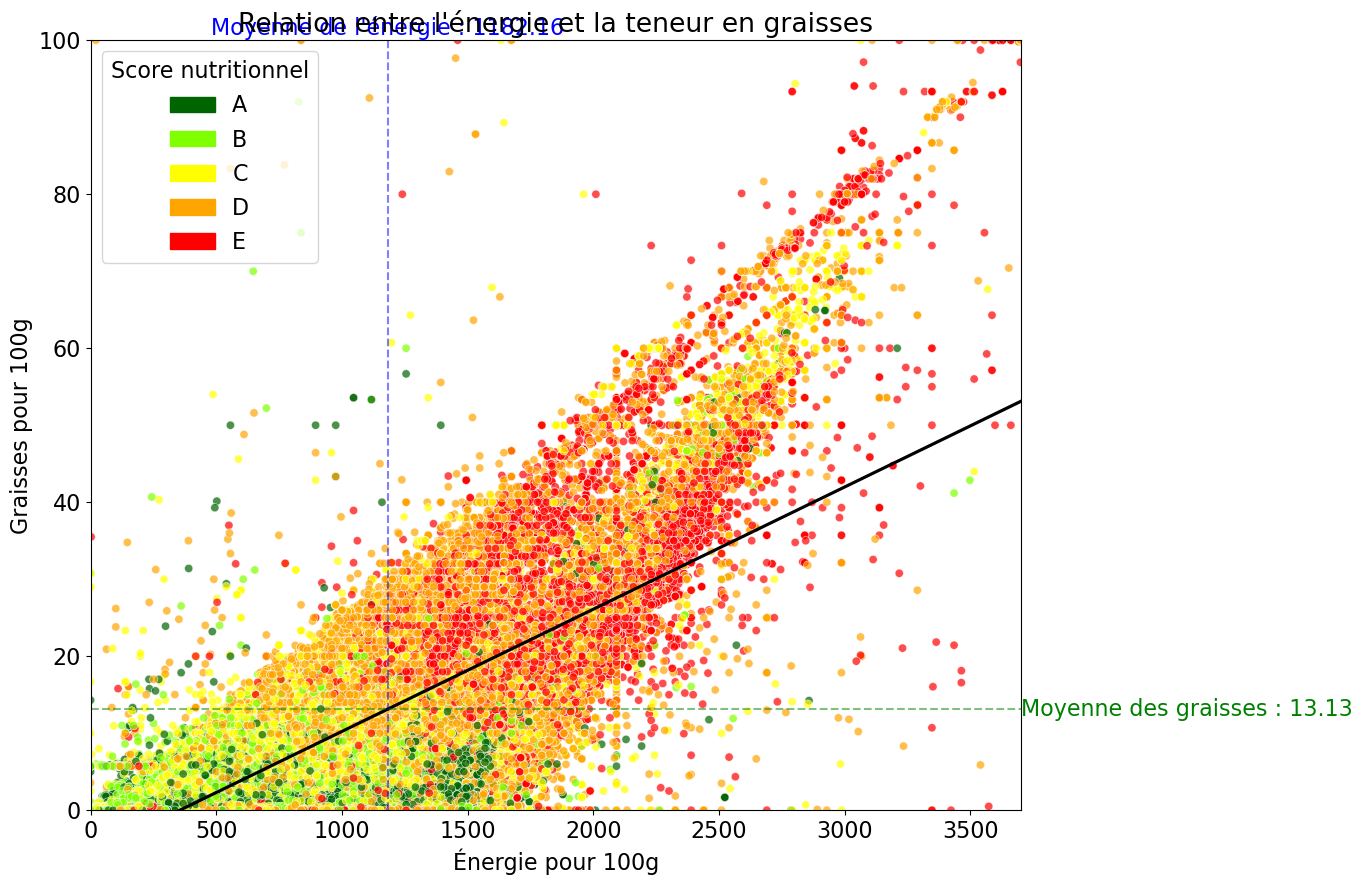

In [35]:
# Création d'une légende personnalisée avec les couleurs correctes pour chaque grade nutritionnel
legend_handles = [
    mpatches.Patch(color='#006400', label='A'),
    mpatches.Patch(color='#7FFF00', label='B'),
    mpatches.Patch(color='yellow', label='C'),
    mpatches.Patch(color='orange', label='D'),
    mpatches.Patch(color='red', label='E')
]

# Définir une palette de couleurs personnalisée pour chaque grade nutritionnel
custom_palette = {'a': '#006400',  # Vert foncé
                  'b': '#7FFF00',  # Vert clair
                  'c': 'yellow',   # Jaune
                  'd': 'orange',   # Orange
                  'e': 'red'}      # Rouge

# Créer le graphique avec les ajustements
plt.figure(figsize=(12, 10))
sns.scatterplot(x="energy_100g", y="fat_100g", hue="nutrition_grade_fr", data=clear_dataset, 
                palette=custom_palette, alpha=0.7)

# Ajouter une ligne de régression linéaire
sns.regplot(x="energy_100g", y="fat_100g", data=clear_dataset, scatter=False, color='black')

# Modifier les limites des axes et ajouter des titres
plt.xlim(0, 3700)
plt.ylim(0, 100)
plt.xlabel("Énergie pour 100g")
plt.ylabel("Graisses pour 100g")
plt.title("Relation entre l'énergie et la teneur en graisses")

# Ajouter la légende personnalisée
plt.legend(handles=legend_handles, title="Score nutritionnel")

# Calculer les moyennes des graisses et de l'énergie
mean_energy = clear_dataset['energy_100g'].mean()
mean_fat = clear_dataset['fat_100g'].mean()

# Ajouter les moyennes au graphique
plt.text(mean_energy, plt.ylim()[1], f"Moyenne de l'énergie : {mean_energy:.2f}", va='bottom', ha='center', color='blue')
plt.text(plt.xlim()[1], mean_fat, f"Moyenne des graisses : {mean_fat:.2f}", va='center', ha='left', color='green')

# Tracer les courbes de régression avec les moyennes
plt.plot([mean_energy, mean_energy], plt.ylim(), linestyle='--', color='blue', alpha=0.5)
plt.plot(plt.xlim(), [mean_fat, mean_fat], linestyle='--', color='green', alpha=0.5)

plt.show()

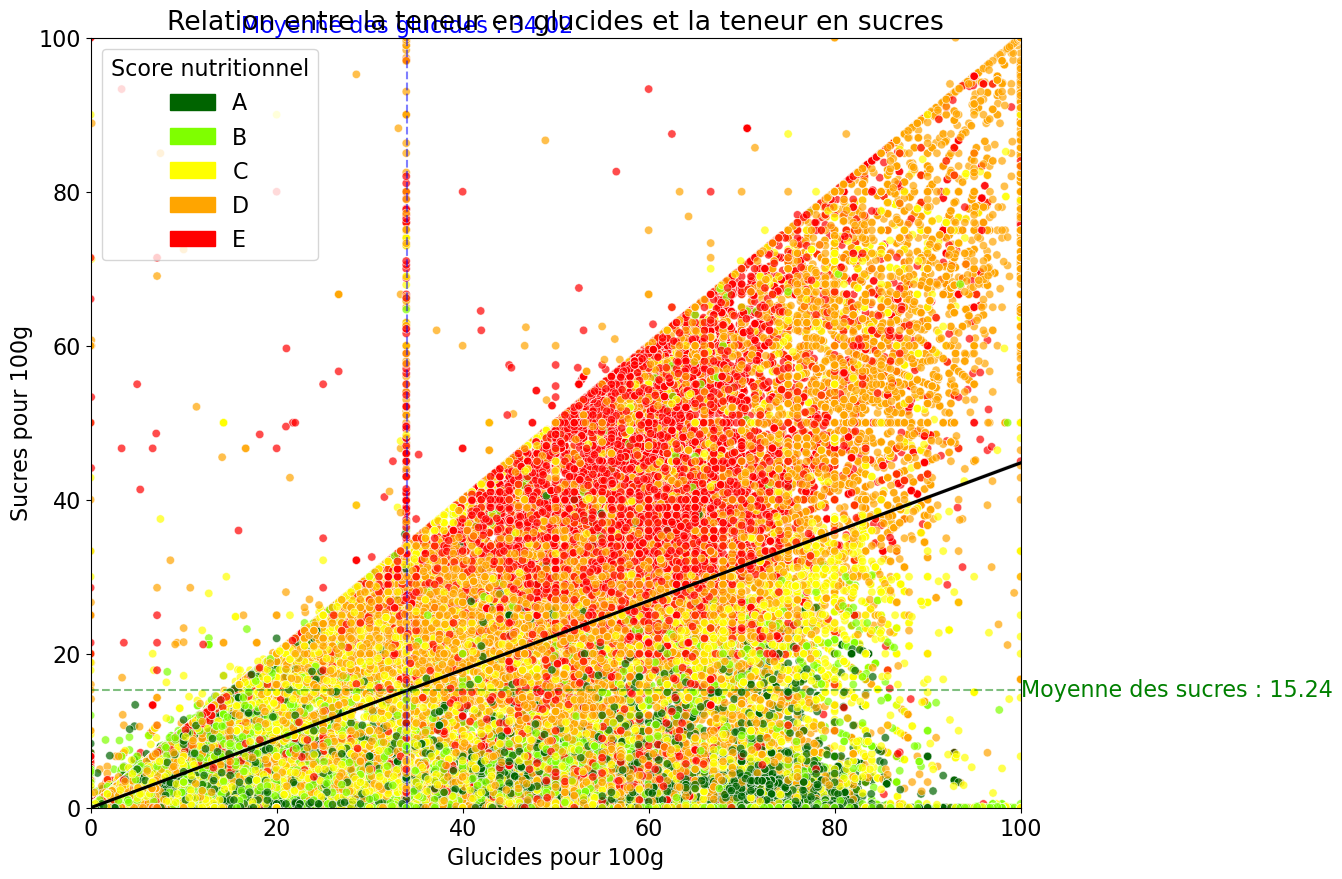

In [41]:
# Création d'une légende personnalisée avec les couleurs correctes pour chaque grade nutritionnel
legend_handles = [
    mpatches.Patch(color='#006400', label='A'),
    mpatches.Patch(color='#7FFF00', label='B'),
    mpatches.Patch(color='yellow', label='C'),
    mpatches.Patch(color='orange', label='D'),
    mpatches.Patch(color='red', label='E')
]

# Définir une palette de couleurs personnalisée pour chaque grade nutritionnel
custom_palette = {'a': '#006400',  # Vert foncé
                  'b': '#7FFF00',  # Vert clair
                  'c': 'yellow',   # Jaune
                  'd': 'orange',   # Orange
                  'e': 'red'}      # Rouge

# Créer le graphique avec les ajustements
plt.figure(figsize=(12, 10))
sns.scatterplot(x="carbohydrates_100g", y="sugars_100g", hue="nutrition_grade_fr", data=clear_dataset, 
                palette=custom_palette, alpha=0.7)

# Ajouter une ligne de régression linéaire
sns.regplot(x="carbohydrates_100g", y="sugars_100g", data=clear_dataset, scatter=False, color='black')

# Modifier les limites des axes et ajouter des titres
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel("Glucides pour 100g")
plt.ylabel("Sucres pour 100g")
plt.title("Relation entre la teneur en glucides et la teneur en sucres")

# Ajouter la légende personnalisée
plt.legend(handles=legend_handles, title="Score nutritionnel",loc="upper left")

# Calculer les moyennes des graisses et de l'énergie
mean_carbohydrates = clear_dataset['carbohydrates_100g'].mean()
mean_sugars = clear_dataset['sugars_100g'].mean()

# Ajouter les moyennes au graphique
plt.text(mean_carbohydrates, plt.ylim()[1], f"Moyenne des glucides : {mean_carbohydrates:.2f}", va='bottom', ha='center', color='blue')
plt.text(plt.xlim()[1], mean_sugars, f"Moyenne des sucres : {mean_sugars:.2f}", va='center', ha='left', color='green')

# Tracer les courbes de régression avec les moyennes
plt.plot([mean_carbohydrates, mean_carbohydrates], plt.ylim(), linestyle='--', color='blue', alpha=0.5)
plt.plot(plt.xlim(), [mean_sugars, mean_sugars], linestyle='--', color='green', alpha=0.5)

plt.show()

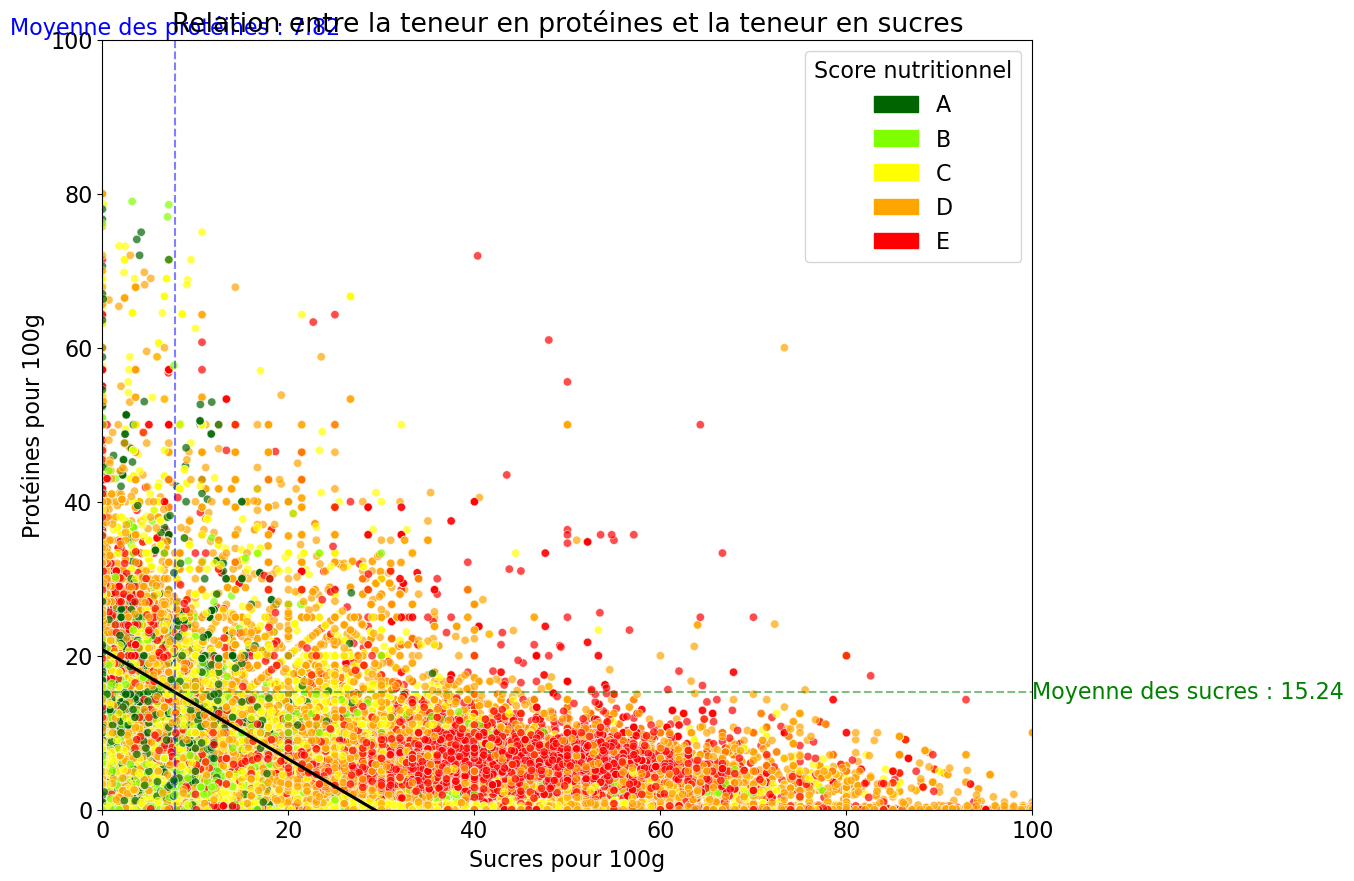

In [37]:
# Création d'une légende personnalisée avec les couleurs correctes pour chaque grade nutritionnel
legend_handles = [
    mpatches.Patch(color='#006400', label='A'),
    mpatches.Patch(color='#7FFF00', label='B'),
    mpatches.Patch(color='yellow', label='C'),
    mpatches.Patch(color='orange', label='D'),
    mpatches.Patch(color='red', label='E')
]

# Définir une palette de couleurs personnalisée pour chaque grade nutritionnel
custom_palette = {'a': '#006400',  # Vert foncé
                  'b': '#7FFF00',  # Vert clair
                  'c': 'yellow',   # Jaune
                  'd': 'orange',   # Orange
                  'e': 'red'}      # Rouge

# Créer le graphique avec les ajustements
plt.figure(figsize=(12, 10))
sns.scatterplot(x="sugars_100g", y="proteins_100g", hue="nutrition_grade_fr", data=clear_dataset, 
                palette=custom_palette, alpha=0.7)

# Ajouter une ligne de régression linéaire
sns.regplot(x="proteins_100g", y="sugars_100g", data=clear_dataset, scatter=False, color='black')

# Modifier les limites des axes et ajouter des titres
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel("Sucres pour 100g")
plt.ylabel("Protéines pour 100g")
plt.title("Relation entre la teneur en protéines et la teneur en sucres")

# Ajouter la légende personnalisée
plt.legend(handles=legend_handles, title="Score nutritionnel")

# Calculer les moyennes des protéines et des sucres
mean_proteins = clear_dataset['proteins_100g'].mean()
mean_sugars = clear_dataset['sugars_100g'].mean()

# Ajouter les moyennes au graphique
plt.text(mean_proteins, plt.ylim()[1], f"Moyenne des protéines : {mean_proteins:.2f}", va='bottom', ha='center', color='blue')
plt.text(plt.xlim()[1], mean_sugars, f"Moyenne des sucres : {mean_sugars:.2f}", va='center', ha='left', color='green')

# Tracer les courbes de régression avec les moyennes
plt.plot([mean_proteins, mean_proteins], plt.ylim(), linestyle='--', color='blue', alpha=0.5)
plt.plot(plt.xlim(), [mean_sugars, mean_sugars], linestyle='--', color='green', alpha=0.5)

plt.show()


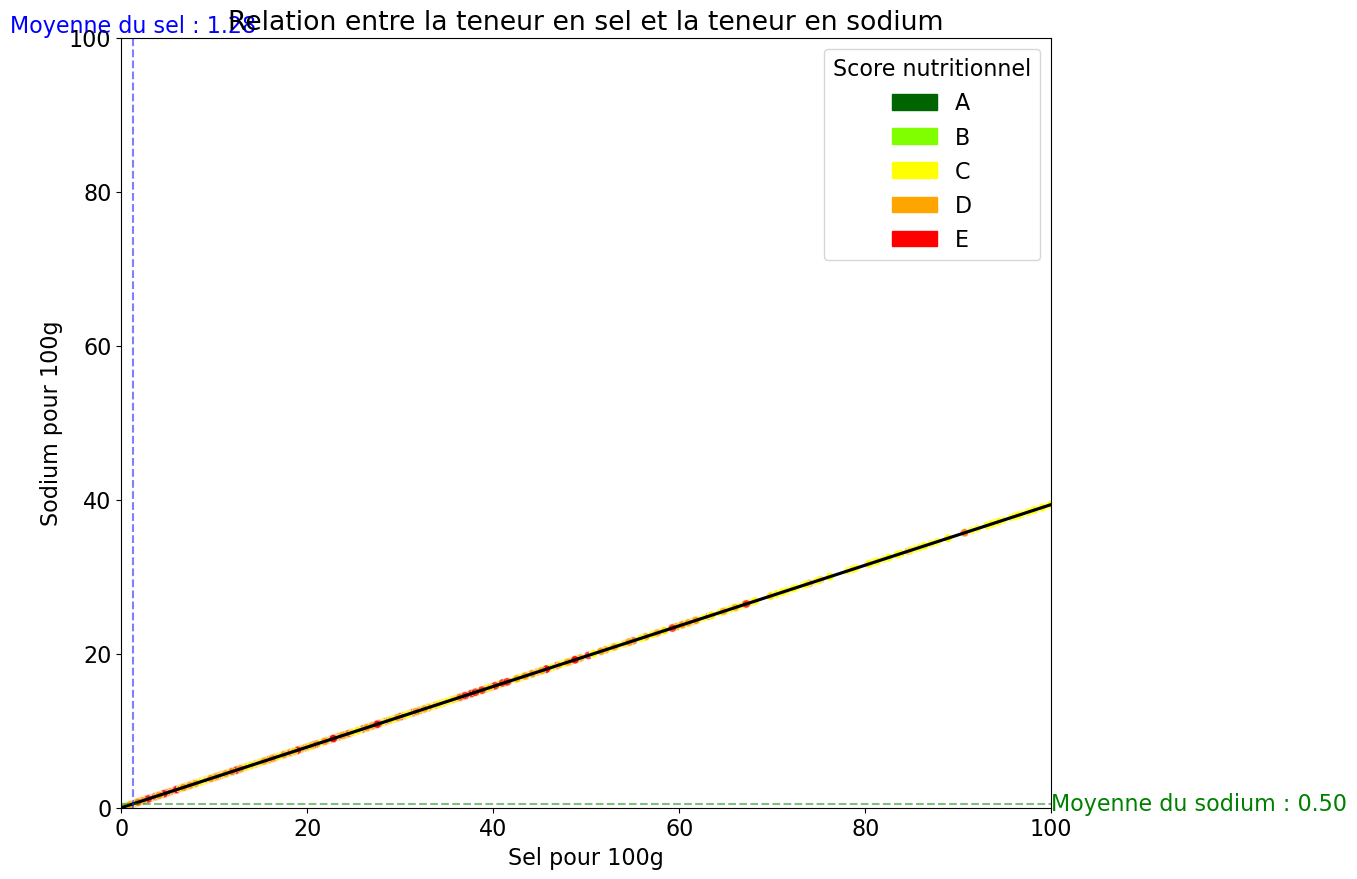

In [38]:
# Création d'une légende personnalisée avec les couleurs correctes pour chaque grade nutritionnel
legend_handles = [
    mpatches.Patch(color='#006400', label='A'),
    mpatches.Patch(color='#7FFF00', label='B'),
    mpatches.Patch(color='yellow', label='C'),
    mpatches.Patch(color='orange', label='D'),
    mpatches.Patch(color='red', label='E')
]

# Définir une palette de couleurs personnalisée pour chaque grade nutritionnel
custom_palette = {'a': '#006400',  # Vert foncé
                  'b': '#7FFF00',  # Vert clair
                  'c': 'yellow',   # Jaune
                  'd': 'orange',   # Orange
                  'e': 'red'}      # Rouge

# Créer le graphique avec les ajustements
plt.figure(figsize=(12, 10))
sns.scatterplot(x="salt_100g", y="sodium_100g", hue="nutrition_grade_fr", data=clear_dataset, 
                palette=custom_palette, alpha=0.7)

# Ajouter une ligne de régression linéaire
sns.regplot(x="salt_100g", y="sodium_100g", data=clear_dataset, scatter=False, color='black')

# Modifier les limites des axes et ajouter des titres
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel("Sel pour 100g")
plt.ylabel("Sodium pour 100g")
plt.title("Relation entre la teneur en sel et la teneur en sodium")

# Ajouter la légende personnalisée
plt.legend(handles=legend_handles, title="Score nutritionnel")

# Calculer les moyennes des graisses et de l'énergie
mean_salt = clear_dataset['salt_100g'].mean()
mean_sodium = clear_dataset['sodium_100g'].mean()

# Ajouter les moyennes au graphique
plt.text(mean_salt, plt.ylim()[1], f"Moyenne du sel : {mean_salt:.2f}", va='bottom', ha='center', color='blue')
plt.text(plt.xlim()[1], mean_sodium, f"Moyenne du sodium : {mean_sodium:.2f}", va='center', ha='left', color='green')

# Tracer les courbes de régression avec les moyennes
plt.plot([mean_salt, mean_salt], plt.ylim(), linestyle='--', color='blue', alpha=0.5)
plt.plot(plt.xlim(), [mean_sodium, mean_sodium], linestyle='--', color='green', alpha=0.5)

plt.show()


# VII. Partitionnement du dataframe en 5 clusters avec le 'groupby' de pandas

Pour partitionner, notre dataset en plusieurs cluster. Nous pouvons utiliser la fonction 'groupby', avec notre variable du nutrition_grade_fr. Cela nous permet d'avoir l'individu moyen pour chacune des classes pour les grades du nutriscore.

Calcul des individus moyens par catégorie selon le nutriscore :

In [42]:
# Utilisation de la fonction drop pour exclure la colonne 'product_name'
numeric_df = clear_dataset.drop(columns=['product_name'])

# Utilisation de la fonction groupby pour regrouper par la variable catégorielle
grouped = numeric_df.groupby('nutrition_grade_fr')

# Calcul des moyennes pour chaque groupe
mean_values = grouped.mean()

# Stockage des données dans un dataframe
clustered_dataset = mean_values

# Afficher le dataset
clustered_dataset.head().round(3)

additives_n  ingredients_from_palm_oil_n  \
nutrition_grade_fr                                             
a                         1.096                        0.001   
b                         1.813                        0.004   
c                         2.040                        0.013   
d                         2.608                        0.022   
e                         2.307                        0.042   

                    ingredients_that_may_be_from_palm_oil_n  energy_100g  \
nutrition_grade_fr                                                         
a                                                     0.021      718.115   
b                                                     0.041      518.962   
c                                                     0.061     1018.103   
d                                                     0.078     1472.486   
e                                                     0.058     1818.876   

                    fat_100g  saturated-fat_100g  carbohydrates_100g  \
nutrition_grade_fr                                                     
a                      2.756               0.373              28.856   
b                      3.861               0.759              17.905   
c                      9.822               1.962              32.474   
d                     16.986               5.528              42.040   
e                     26.577              13.408              40.491   

                    sugars_100g  fiber_100g  proteins_100g  salt_100g  \
nutrition_grade_fr                                                      
a                         3.512       4.175          8.313      0.347   
b                         5.259       1.563          5.033      0.543   
c                        11.214       3.157          7.125      1.801   
d                        21.829       2.339          8.548      1.645   
e                        27.019       1.415          9.247      1.518   

                    sodium_100g  
nutrition_grade_fr               
a                         0.137  
b                         0.214  
c                         0.709  
d                         0.648  
e                         0.598

# VIII. L'analyse en composantes principales

**Préparation des données pour l'analyse ACP**

In [43]:
# Stocker les features pour notre analyse
cols = [
    "additives_n",
    "ingredients_from_palm_oil_n",
    "ingredients_that_may_be_from_palm_oil_n",
    "energy_100g",
    "fat_100g",
    "saturated-fat_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g",
    "sodium_100g"
]

In [44]:
# Création d'un dataframe df pour l'analyse
df = clear_dataset[cols]
X = df.values

In [45]:
# Création et distinction entre les variables quantitatives et qualitatives
names = clear_dataset['nutrition_grade_fr']
features = nutrient_features

**Centrer et réduire nos données**

In [46]:
# Scaler les données en utilisation la fonction de sklearn 'StandardScaler'
scaler = StandardScaler()

In [47]:
# Adapter le scaler aux données pour calculer la moyenne et l'écart-type
scaler.fit(X)

# Transformer les données originales en utilisant la moyenne et l'écart-type calculés
X_scaled = scaler.transform(X)

# Vérification que nos moyennes sont égales à 0 et nos écart-type à 1
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5    6    7    8    9    10   11
mean  0.0  0.0  0.0  0.0  0.0 -0.0 -0.0 -0.0 -0.0  0.0 -0.0 -0.0
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

**Application de la PCA / ACP**

In [48]:
# Sélection du nombre de composantes
n_components = 6

# Instanciation de l'ACP
pca = PCA(n_components=n_components)

# Entrainement sur les données "X"
pca.fit(X_scaled)

PCA(n_components=6)

**Visualisation de la variance captée par nos différentes composantes**

In [49]:
# Création d'une variable pour visualiser la valeur de la variance stockée par chacune des composantes
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round(2)

# Afficher les valeurs correspondantes
print(scree)
print(scree.cumsum().round(2))
print('Cumul:',sum(scree))

[22.6  17.58 15.28 11.83  9.14  7.36]
[22.6  40.18 55.46 67.29 76.43 83.79]
Cumul: 83.79


In [50]:
# Définir une variable pour stocker nos composantes
x_list = range(1, n_components+1)

**Graphique : 'Eboulis des valeurs propres'**

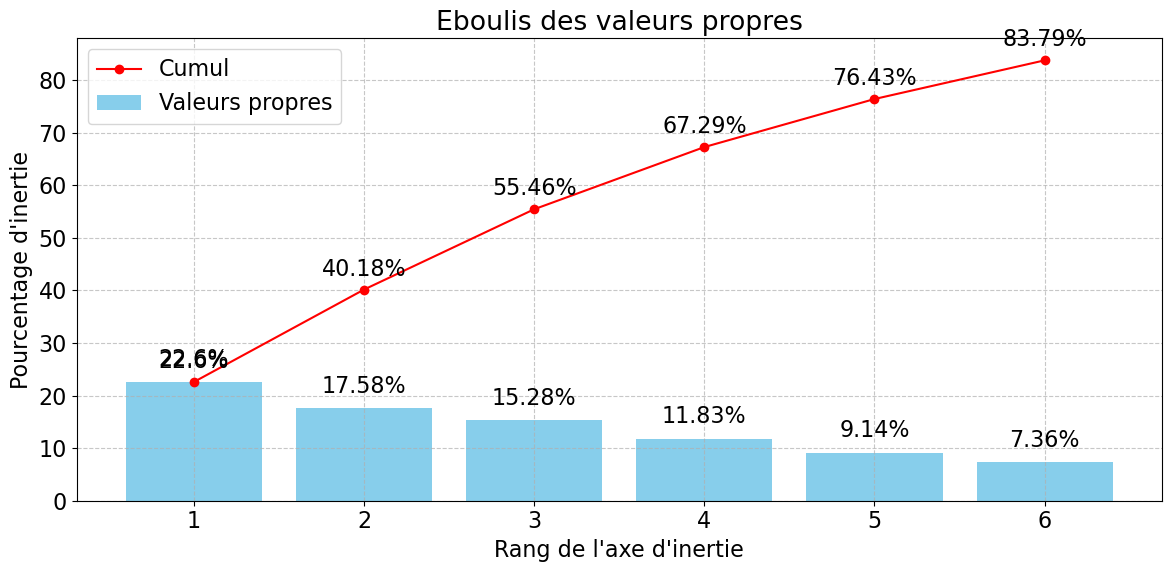

In [51]:
# Création d'un graphique pour afficher et illustrer ces résultats

plt.figure(figsize=(12, 6))

plt.bar(x_list, scree, color='skyblue', label='Valeurs propres')
plt.plot(x_list, scree_cum, c="red", marker='o', label='Cumul')

plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)

# Ajout des étiquettes de données
for i, value in enumerate(scree):
    plt.text(x_list[i], value + 2, f'{value}%', ha='center', va='bottom')

# Ajout d'annotations pour le cumul
for i, value in enumerate(scree_cum):
    plt.annotate(f'{value}%', (x_list[i], value), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

**Analyse des composantes**

In [52]:
# Stockage des données de nos composantes dans un dataframe
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.T

F1        F2        F3  \
additives_n                             -0.009114 -0.169566  0.288257   
ingredients_from_palm_oil_n              0.101891 -0.058261  0.122686   
ingredients_that_may_be_from_palm_oil_n  0.027333 -0.082894  0.129953   
energy_100g                              0.574901  0.054476  0.104266   
fat_100g                                 0.480381  0.251842 -0.167597   
saturated-fat_100g                       0.430782  0.181067 -0.115303   
carbohydrates_100g                       0.284125 -0.306161  0.431261   
sugars_100g                              0.233286 -0.349403  0.396908   
fiber_100g                               0.216677  0.039125 -0.020848   
proteins_100g                            0.180853  0.319129 -0.258914   
salt_100g                               -0.116475  0.520871  0.459195   
sodium_100g                             -0.116475  0.520871  0.459195   

                                               F4        F5        F6  
additives_n                              0.430970  0.174507 -0.475465  
ingredients_from_palm_oil_n              0.365441  0.294916  0.829793  
ingredients_that_may_be_from_palm_oil_n  0.535264  0.397691 -0.207383  
energy_100g                             -0.056959  0.011255 -0.066527  
fat_100g                                 0.165980 -0.158880 -0.027959  
saturated-fat_100g                       0.260274 -0.329655  0.011169  
carbohydrates_100g                      -0.290411  0.113425 -0.028097  
sugars_100g                             -0.110228 -0.278506  0.030990  
fiber_100g                              -0.438656  0.586066  0.011354  
proteins_100g                           -0.065804  0.393144 -0.185496  
salt_100g                               -0.034893 -0.030863  0.019346  
sodium_100g                             -0.034894 -0.030862  0.019346

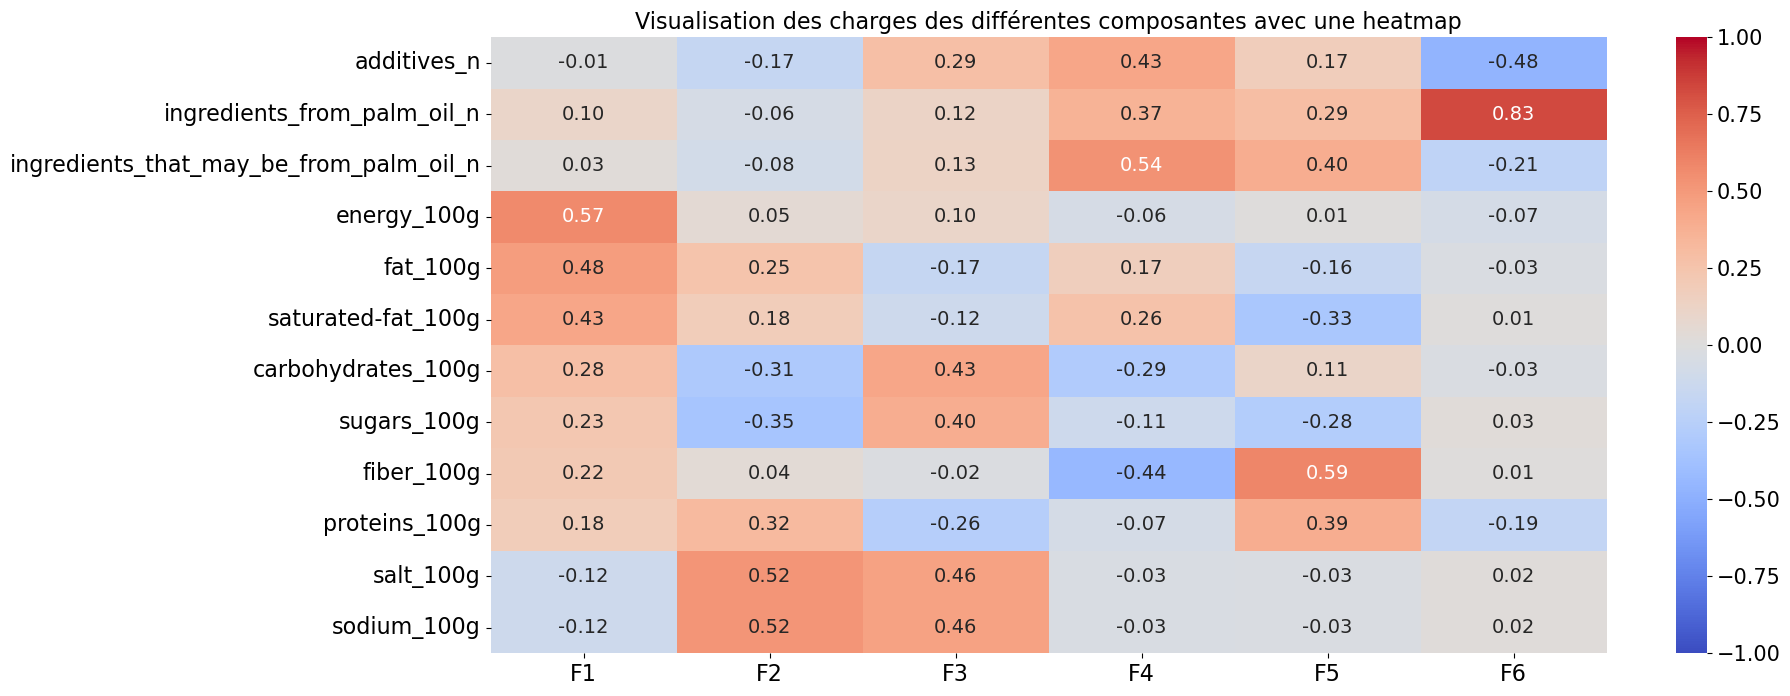

In [53]:
# Visualisation des données via une HeatMap de seaborn
fig, ax = plt.subplots(figsize=(18, 8))
heatmap = sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f", annot_kws={"size": 14})
heatmap.set_title("Visualisation des charges des différentes composantes avec une heatmap", fontsize=16)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)

[Text(0, 0.5, 'additives_n'),
 Text(0, 1.5, 'ingredients_from_palm_oil_n'),
 Text(0, 2.5, 'ingredients_that_may_be_from_palm_oil_n'),
 Text(0, 3.5, 'energy_100g'),
 Text(0, 4.5, 'fat_100g'),
 Text(0, 5.5, 'saturated-fat_100g'),
 Text(0, 6.5, 'carbohydrates_100g'),
 Text(0, 7.5, 'sugars_100g'),
 Text(0, 8.5, 'fiber_100g'),
 Text(0, 9.5, 'proteins_100g'),
 Text(0, 10.5, 'salt_100g'),
 Text(0, 11.5, 'sodium_100g')]

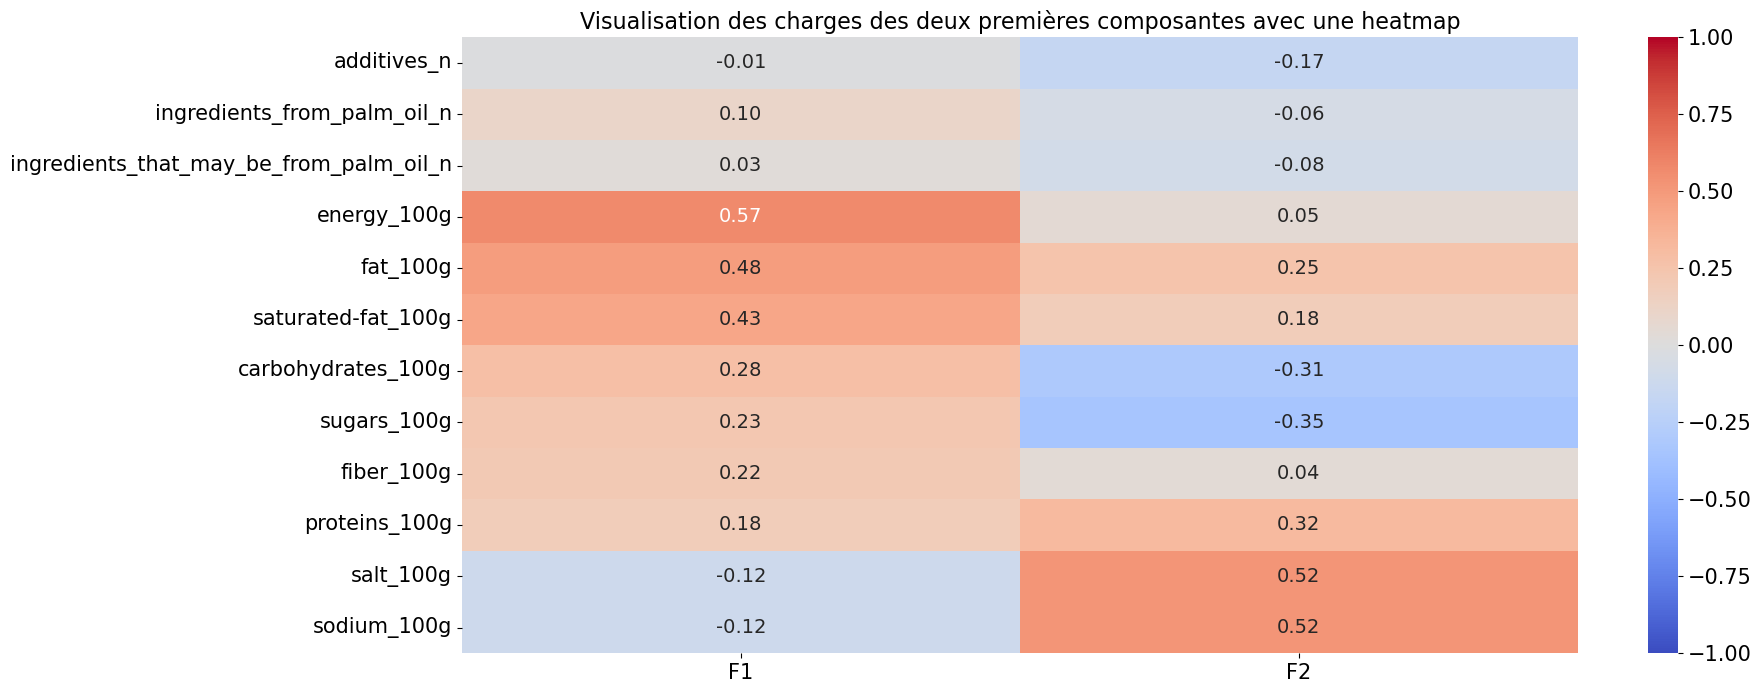

In [54]:
# Sélectionner les deux premières composantes
pcs_2 = pcs.iloc[:2, :]

# Visualisation des données via une HeatMap de seaborn
fig, ax = plt.subplots(figsize=(18, 8))
heatmap = sns.heatmap(pcs_2.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f", annot_kws={"size": 14})
heatmap.set_title("Visualisation des charges des deux premières composantes avec une heatmap", fontsize=16)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)

# Grossir les écritures des axes
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)

**Etude des corrélations : avec le cercle des corrélations**

In [55]:
# Définir les axe x,y
x, y = 0,1

Cercle de corrélation pour F1 & F2

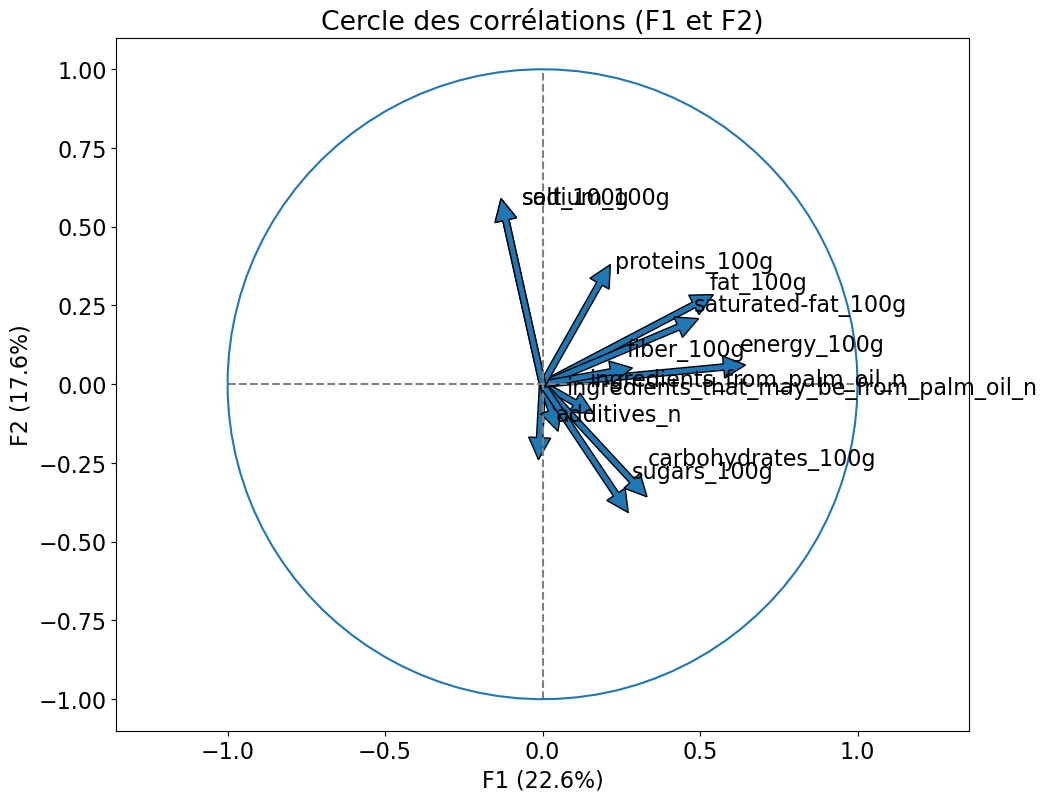

In [56]:
# Création du graphique pour le cercle des corrélations
fig, ax = plt.subplots(figsize=(11, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])
    
# Affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# Nom des axes, avec le pourcentage d'inertie expliquée
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an)) 
plt.axis('equal')
plt.show(block=False)

Cercle de corrélation pour F3 & F4

In [57]:
# Définir les axe x,y
x, y = 2,3

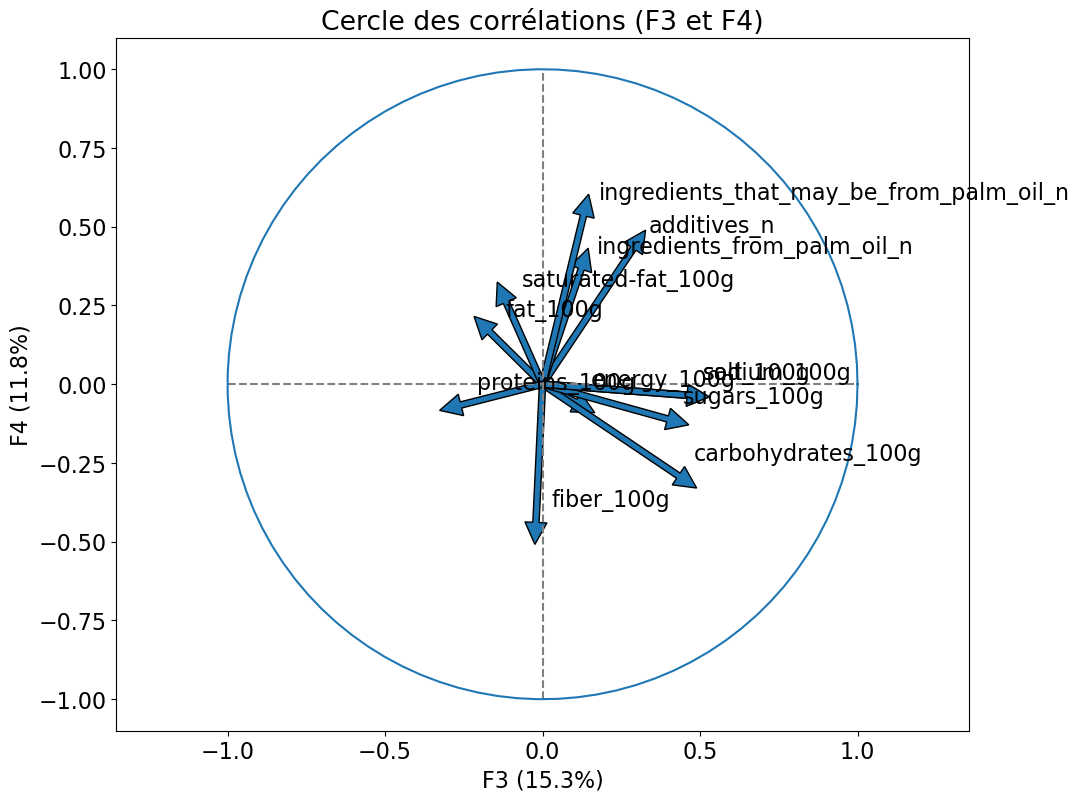

In [58]:
# Création du graphique pour le cercle des corrélations
fig, ax = plt.subplots(figsize=(11, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[2, i],  #0 for PC1
             pca.components_[3, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[2, i] + 0.05,
             pca.components_[3, i] + 0.05,
             features[i])
    
# Affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# Nom des axes, avec le pourcentage d'inertie expliquée
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an)) 
plt.axis('equal')
plt.show(block=False)

Cercle de corrélation pour F5 & F6

In [59]:
x, y = 4,5

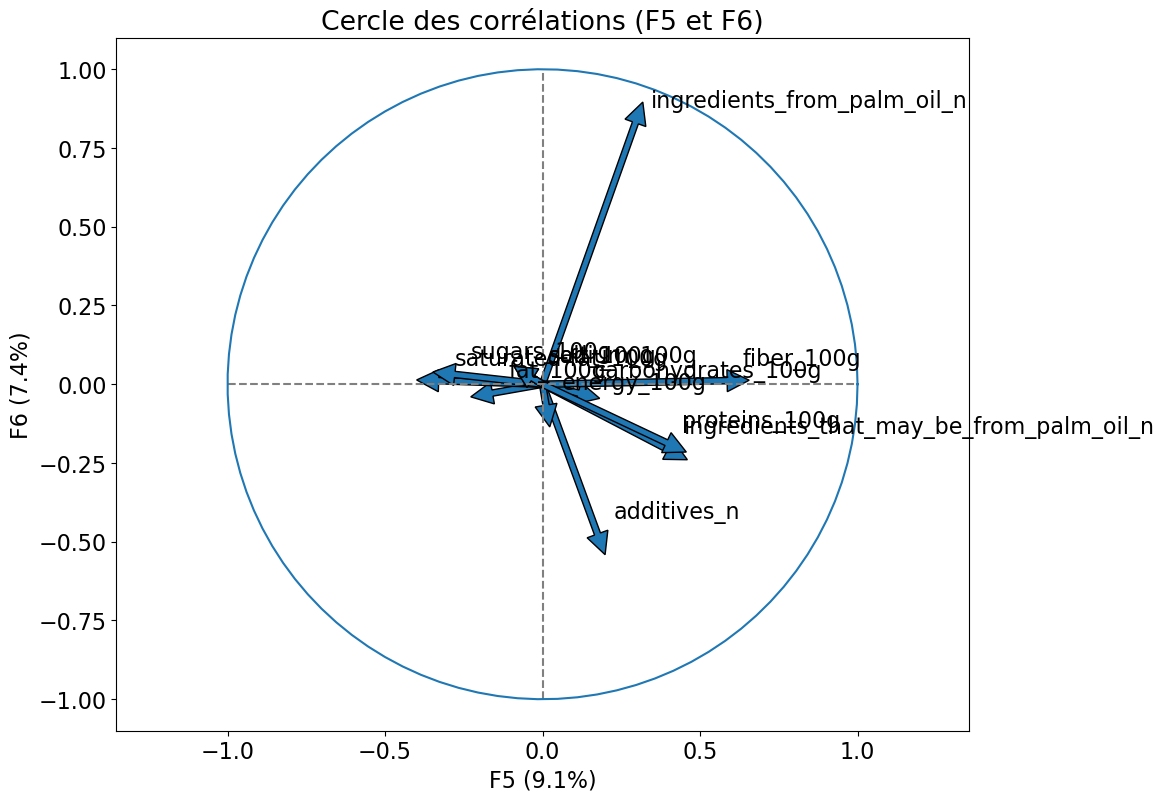

In [60]:
# Création du graphique pour le cercle des corrélations
fig, ax = plt.subplots(figsize=(11, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[4, i],  #0 for PC1
             pca.components_[5, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[4, i] + 0.05,
             pca.components_[5, i] + 0.05,
             features[i])
    
# Affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# Nom des axes, avec le pourcentage d'inertie expliquée
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an)) 
plt.axis('equal')
plt.show(block=False)

In [61]:
X_proj = pca.transform(X_scaled)

In [64]:
x_y = (0,1)

C:\Users\justi\AppData\Local\Temp\ipykernel_19656\3951460690.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'nutrition_grade_fr'] = clear_dataset['nutrition_grade_fr']


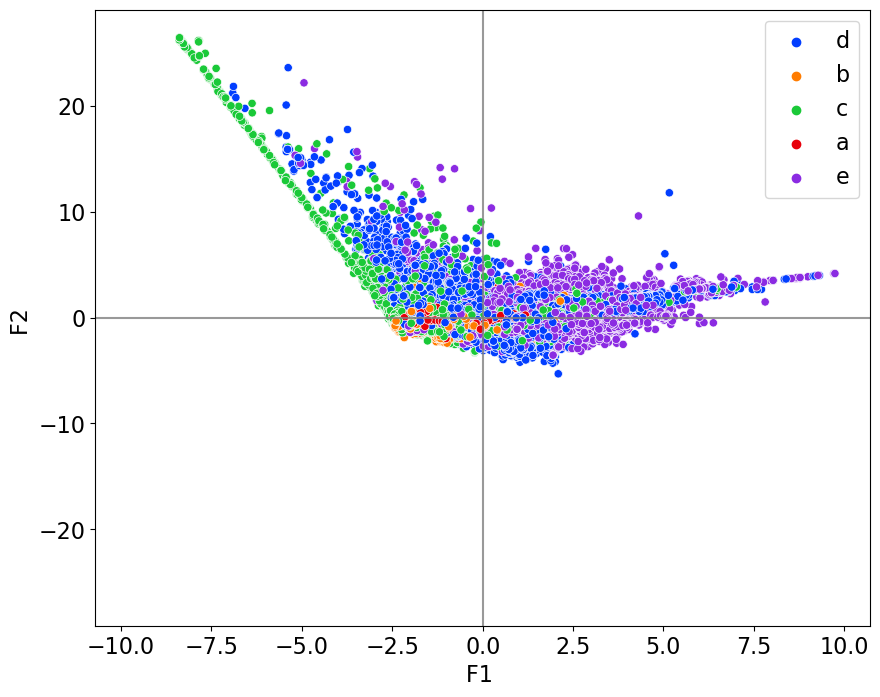

In [65]:
def display_factorial_planes(X_projected, x_y, pca=None, labels='nutrition_grade_fr', clusters=None, alpha=1, figsize=[10,8], marker="."):

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (16, 10)

    # On vérifie la variable axis 
    if not len(x_y) == 2: 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y) >= X_.shape[1]: 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=labels, palette='bright')

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca: 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else: 
        v1 = v2 = ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() * 1.1
    y_max = np.abs(X_[:, y]).max() * 1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom=-y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage de la légende
    plt.legend(loc='best')

# Réimporter la colonne 'nutrition_grade_fr' dans le DataFrame df
df.loc[:, 'nutrition_grade_fr'] = clear_dataset['nutrition_grade_fr']

x_y = [0, 1]
display_factorial_planes(X_proj, x_y, labels=df['nutrition_grade_fr'])


**Préparation des données pour l'analyse ACP**

In [167]:
# Stocker les features pour notre analyse
cols = [
    "additives_n",
    "ingredients_from_palm_oil_n",
    "ingredients_that_may_be_from_palm_oil_n",
    "energy_100g",
    "fat_100g",
    "saturated-fat_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g",
    "sodium_100g"
]

In [170]:
# Création d'un dataframe df pour l'analyse
df_cluster = clustered_dataset[cols]
X2 = df_cluster.values

In [174]:
# Création et distinction entre les variables quantitatives et qualitatives
target = clear_dataset['nutrition_grade_fr']
features = nutrient_features

**Centrer & réduire les données**

In [175]:
# Scaler les données en utilisation la fonction de sklearn 'StandardScaler'
scaler = StandardScaler()

In [178]:
# Adapter le scaler aux données pour calculer la moyenne et l'écart-type
scaler.fit(X2)

# Transformer les données originales en utilisant la moyenne et l'écart-type calculés
X2_scaled = scaler.transform(X2)

# Vérification que nos moyennes sont égales à 0 et nos écart-type à 1
idx2 = ["mean", "std"]
pd.DataFrame(X2_scaled).describe().round(2).loc[idx2, :]

0     1     2     3     4     5     6     7     8     9     10    11
mean  0.00  0.00  0.00 -0.00  0.00 -0.00  0.00  0.00  0.00 -0.00  0.00 -0.00
std   1.12  1.12  1.12  1.12  1.12  1.12  1.12  1.12  1.12  1.12  1.12  1.12

**Application de la PCA / ACP**

In [179]:
# Sélection du nombre de composantes
n_components = 3

# Instanciation de l'ACP
pca = PCA(n_components=n_components)

# Entrainement sur les données "X"
pca.fit(X2_scaled)

PCA(n_components=3)

**Visualisation de la variance captée par nos différentes composantes**

In [184]:
# Création d'une variable pour visualiser la valeur de la variance stockée par chacune des composantes
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round(2)

# Afficher les valeurs correspondantes
print(scree)
print(scree.cumsum().round(2))
print('Cumul:',sum(scree))

[73.29 13.8  11.05]
[73.29 87.09 98.14]
Cumul: 98.14


In [185]:
# Définir une variable pour stocker nos composantes
x_list = range(1, n_components+1)

**Graphique : 'Eboulis des valeurs propres'**

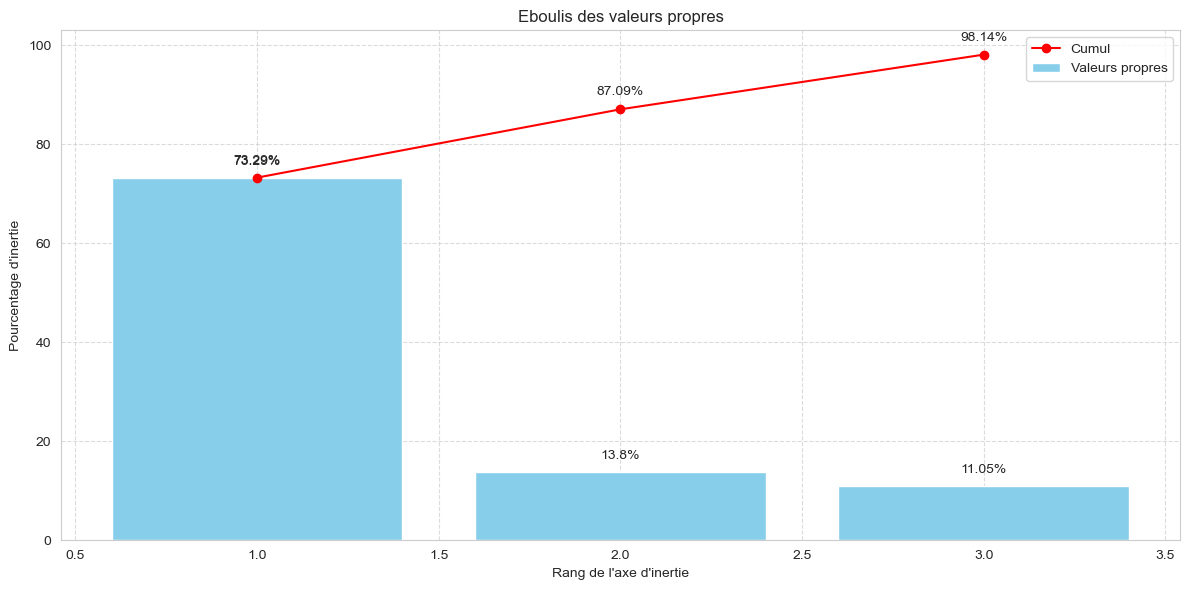

In [186]:
# Création d'un graphique pour afficher et illustrer ces résultats

plt.figure(figsize=(12, 6))

plt.bar(x_list, scree, color='skyblue', label='Valeurs propres')
plt.plot(x_list, scree_cum, c="red", marker='o', label='Cumul')

plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)

# Ajout des étiquettes de données
for i, value in enumerate(scree):
    plt.text(x_list[i], value + 2, f'{value}%', ha='center', va='bottom')

# Ajout d'annotations pour le cumul
for i, value in enumerate(scree_cum):
    plt.annotate(f'{value}%', (x_list[i], value), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

**Analyse des composantes**

In [187]:
# Stockage des données de nos composantes dans un dataframe
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.T

F1        F2        F3
additives_n                              0.291052 -0.356207  0.081669
ingredients_from_palm_oil_n              0.318060  0.080215 -0.251598
ingredients_that_may_be_from_palm_oil_n  0.278470 -0.323637  0.289422
energy_100g                              0.327813  0.171940 -0.066557
fat_100g                                 0.326345  0.072654 -0.196678
saturated-fat_100g                       0.296402  0.137289 -0.372725
carbohydrates_100g                       0.295820  0.292875  0.223946
sugars_100g                              0.332689  0.030867 -0.120093
fiber_100g                              -0.168892  0.468858  0.537747
proteins_100g                            0.217871  0.585054  0.069379
salt_100g                                0.283355 -0.172346  0.390940
sodium_100g                              0.283355 -0.172345  0.390939

<Axes: >

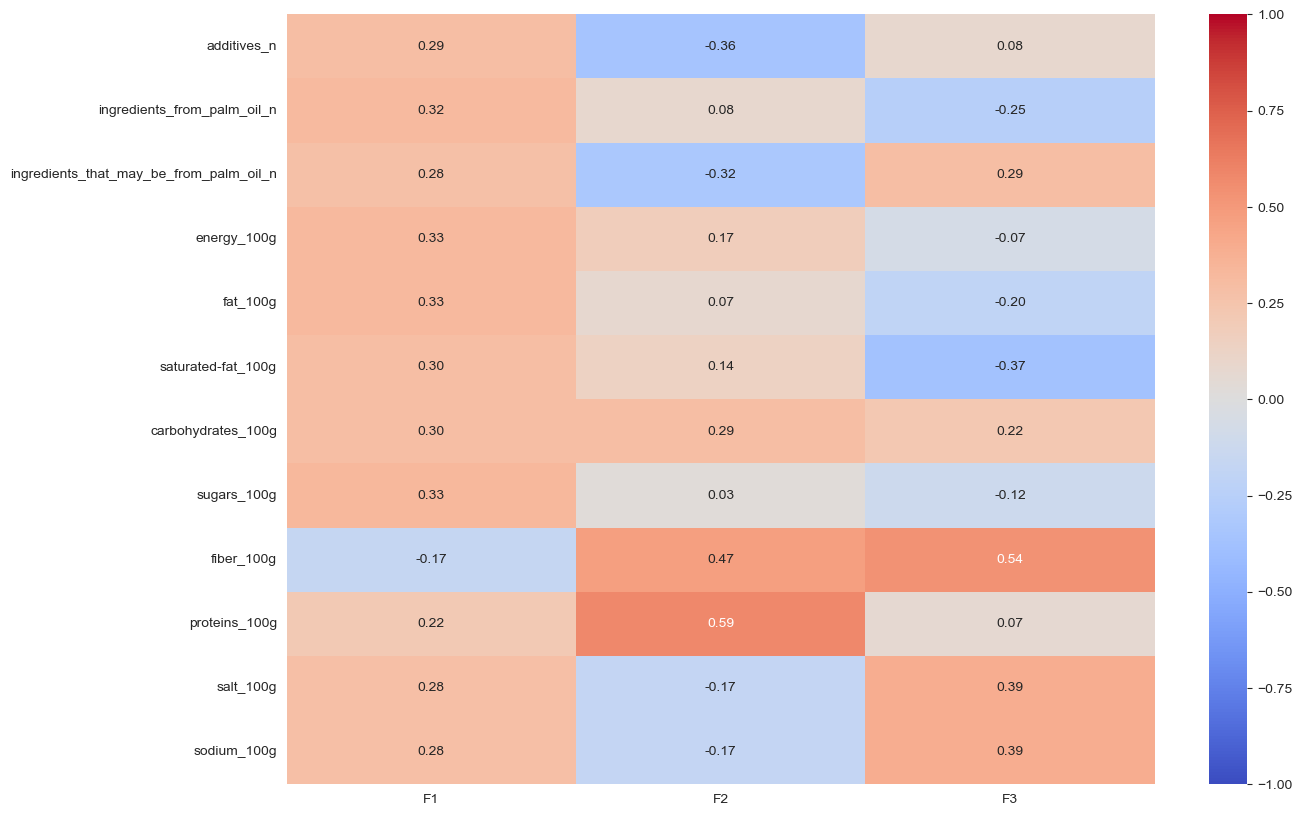

In [190]:
# Visualisation des données via une HeatMap de seaborn
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

**Etude des corrélations : avec le cercle des corrélations**

In [191]:
# Définir les axe x,y
x, y = 0,1

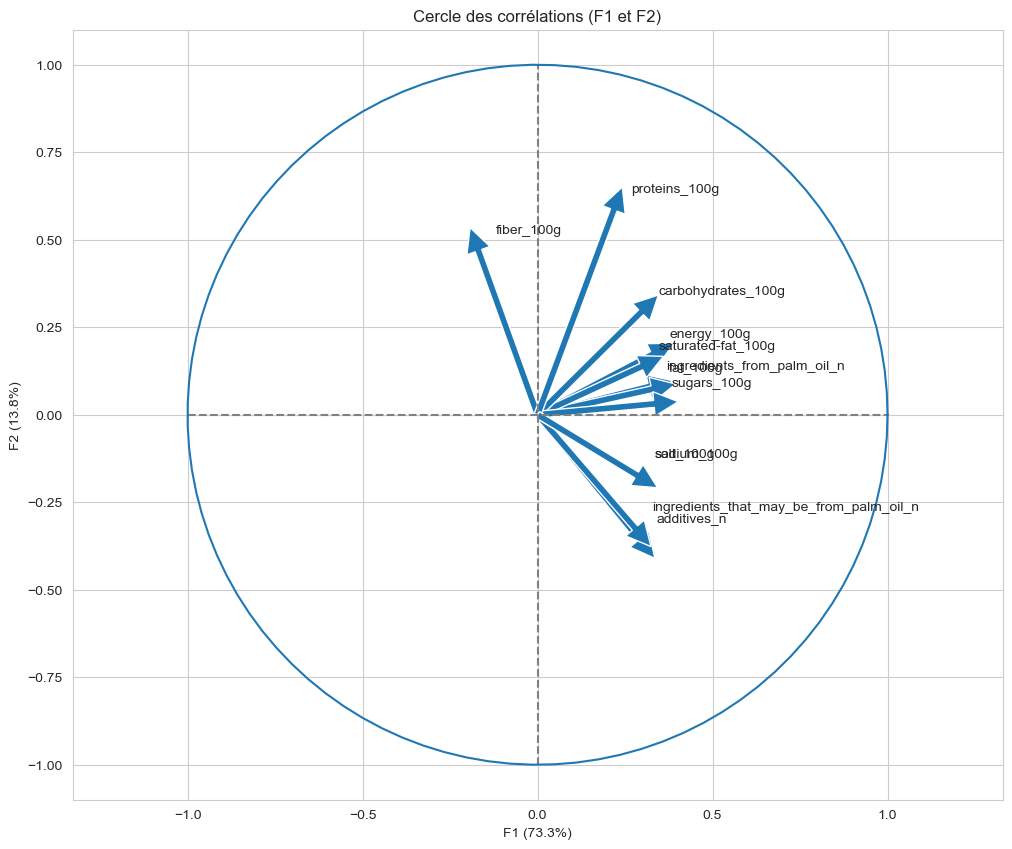

In [192]:
# Création du graphique pour le cercle des corrélations
fig, ax = plt.subplots(figsize=(12, 10))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])
    
# Affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# Nom des axes, avec le pourcentage d'inertie expliquée
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an)) 
plt.axis('equal')
plt.show(block=False)

In [193]:
X_proj = pca.transform(X2_scaled)

In [194]:
x_y = (0,1)
x_y

(0, 1)

In [205]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
   
    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

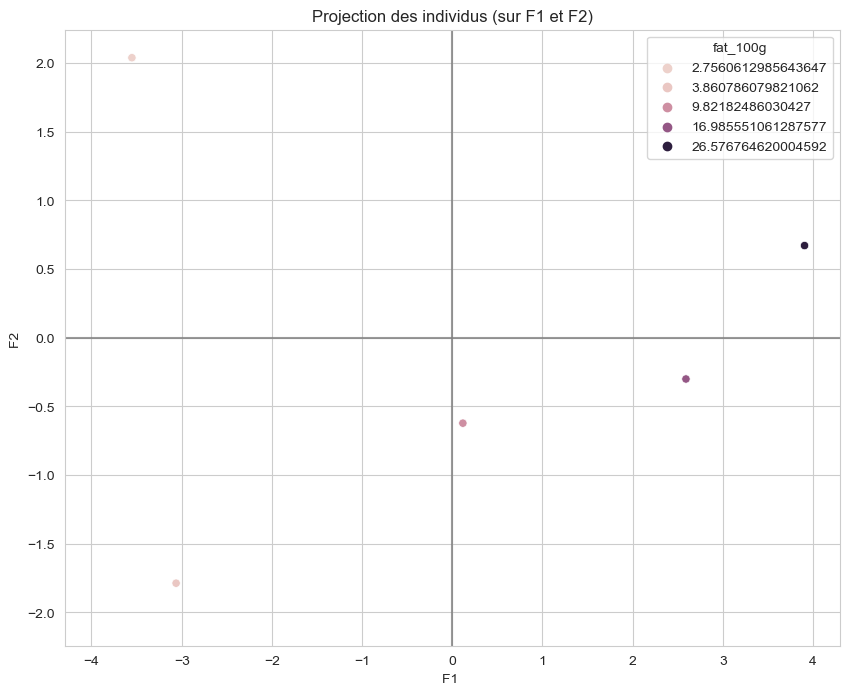

In [206]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=df_cluster['fat_100g'])

# IX. ANOVA : présentée pendant la soutenance

Faire une analyse ANOVA pour mettre en avant l'évolution de trois de nos variables quantitatives étant la teneur en "sucres, en graisses & en protéines"

In [66]:
# Copie du dataframe consolidé
anova_data = clear_dataset.copy()

ANOVA sur les variables salt_100g & le nutriscore

In [67]:
# Analyse ANOVA sur l'énergie pour 100g et le nutrition grade
X = 'nutrition_grade_fr'
Y = 'salt_100g'

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print('n² =',round(eta_squared(anova_data[X], anova_data[Y]), 5))

n² = 0.0215


Boxplot pour visuliser les données entre le sel et le nutriscore

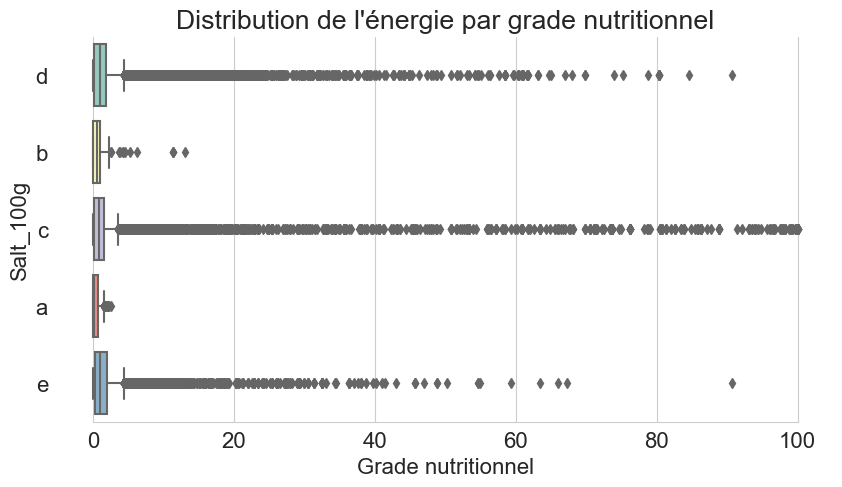

In [68]:
# Définir le style seaborn
sns.set_style("whitegrid")

# Définir la taille de la figure
plt.figure(figsize=(10, 5))

# Créer le boxplot avec des couleurs personnalisées
sns.boxplot(x='salt_100g', y='nutrition_grade_fr', data=anova_data, palette="Set3", orient='h')

# Ajouter un titre et des labels d'axes
plt.title('Distribution de l\'énergie par grade nutritionnel')
plt.xlabel('Grade nutritionnel')
plt.ylabel('Salt_100g')

# Afficher la médiane sur le graphique
sns.despine(trim=True, left=True)
plt.show()

ANOVA sur les variables 'sugars_100g' & le nutriscore

In [69]:
# Analyse ANOVA sur l'énergie pour 100g et le nutrition grade
X = 'nutrition_grade_fr'
Y = 'sugars_100g'

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print('n² =',round(eta_squared(anova_data[X], anova_data[Y]), 5))

n² = 0.20268


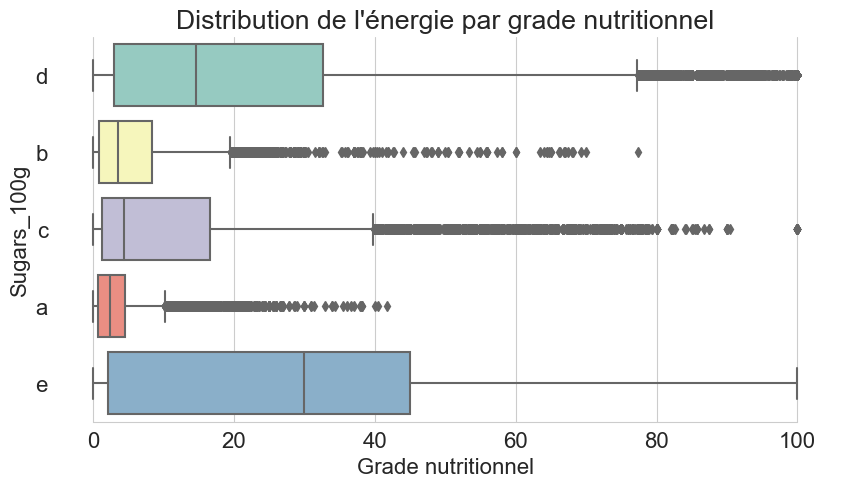

In [70]:
# Définir le style seaborn
sns.set_style("whitegrid")

# Définir la taille de la figure
plt.figure(figsize=(10, 5))

# Créer le boxplot avec des couleurs personnalisées
sns.boxplot(x='sugars_100g', y='nutrition_grade_fr', data=anova_data, palette="Set3", orient='h')

# Ajouter un titre et des labels d'axes
plt.title('Distribution de l\'énergie par grade nutritionnel')
plt.xlabel('Grade nutritionnel')
plt.ylabel('Sugars_100g')

# Afficher la médiane sur le graphique
sns.despine(trim=True, left=True)
plt.show()

ANOVA sur les variables 'fat_100g' & le nutriscore

In [71]:
# Analyse ANOVA sur l'énergie pour 100g et le nutrition grade
X = 'nutrition_grade_fr'
Y = 'fat_100g'

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print('n² =',round(eta_squared(anova_data[X], anova_data[Y]), 5))

n² = 0.30411


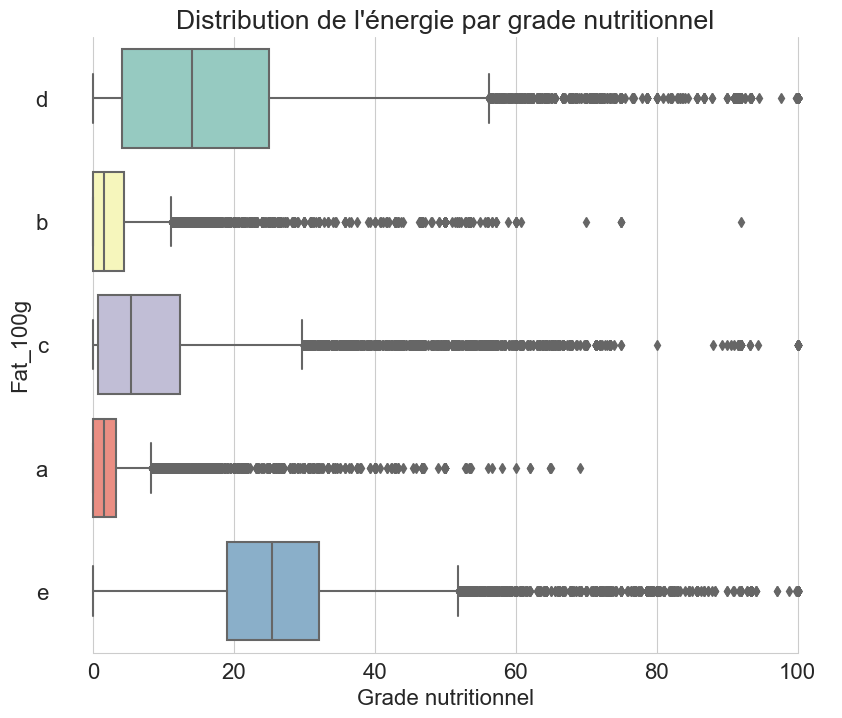

In [72]:
# Définir le style seaborn
sns.set_style("whitegrid")

# Définir la taille de la figure
plt.figure(figsize=(10, 8))

# Créer le boxplot avec des couleurs personnalisées
sns.boxplot(x='fat_100g', y='nutrition_grade_fr', data=anova_data, palette="Set3", orient='h')

# Ajouter un titre et des labels d'axes
plt.title('Distribution de l\'énergie par grade nutritionnel')
plt.xlabel('Grade nutritionnel')
plt.ylabel('Fat_100g')

# Afficher la médiane sur le graphique
sns.despine(trim=True, left=True)
plt.show()

In [73]:
# Créer le modèle ANOVA pour salt_100g en fonction de nutrition_score_fr
model_salt = ols('salt_100g ~ C(nutrition_grade_fr)', data=anova_data).fit()
anova_table_salt = sm.stats.anova_lm(model_salt, typ=2)
print("ANOVA pour salt_100g :\n", anova_table_salt)

# Créer le modèle ANOVA pour sugars_100g en fonction de nutrition_score_fr
model_sugars = ols('sugars_100g ~ C(nutrition_grade_fr)', data=anova_data).fit()
anova_table_sugars = sm.stats.anova_lm(model_sugars, typ=2)
print("\nANOVA pour sugars_100g :\n", anova_table_sugars)

# Créer le modèle ANOVA pour fat_100g en fonction de nutrition_score_fr
model_fat = ols('fat_100g ~ C(nutrition_grade_fr)', data=anova_data).fit()
anova_table_fat = sm.stats.anova_lm(model_fat, typ=2)
print("\nANOVA pour fat_100g :\n", anova_table_fat)


ANOVA pour salt_100g :
                              sum_sq        df           F  PR(>F)
C(nutrition_grade_fr)  5.359363e+04       4.0  905.074041     0.0
Residual               2.439614e+06  164798.0         NaN     NaN

ANOVA pour sugars_100g :
                              sum_sq        df             F  PR(>F)
C(nutrition_grade_fr)  1.311925e+07       4.0  10473.070773     0.0
Residual               5.160919e+07  164798.0           NaN     NaN

ANOVA pour fat_100g :
                              sum_sq        df             F  PR(>F)
C(nutrition_grade_fr)  1.180252e+07       4.0  18004.628498     0.0
Residual               2.700739e+07  164798.0           NaN     NaN


# X. ANOVA : 'Test Paramétrique'(après la soutenance)

Consigne : tester nos données avec le test de Shapiro-Wilk pour démontrer si les valeurs prisent par nos variables suivant une distribution gaussienne ou non.

Etape cruciale avant une analyse statistique, "paramétrique", type ANOVA.

Une ANOVA, 'Analyse de la variance', est un modèle statistique dit paramétrique, ce qui indique la nécessité de vérifier des conditions au préalable, si nous pouvons appliquer cette méthode ou non sur notre jeu de données.
Dans le cas de l'ANOVA, nous devons vérifier si nos données suivent bien une distribution Gaussienne / normale.
Un test, qu'on appelle, le test de Shapiro-Wilk nous permet de valider ou non cette hypothèse.

Ce test se base sous la formulation de deux hypothèses : 
- La première, 'hypothèse nulle': l'échantillon est issu d'une population normale- La seconde, 'hypothèse alternative' : l'échantillon n'est pas issu d'une population normale

Le test de Shapiro-Wilk va donc nous permettre de calculer un indicateur, appelé 'P-value',qui est la probabilité que notre échantillon suive une loi normale ou non.

La valeur de référence de P-Value est 0.05, où si notre P-Value calculé est inférieur à cette valeur, nous sommes dans la situation de rejeter l'hypothèse nulle et de conclure que l'échantillon n'est pas issu d'une population normale ou inversement, si la valeur est supérieure à 0.05.

Dans notre situation, nous avons une variable qualitative qui est le nutriscore, avec 5 modalités différentes étant A,B,C,D & E.
Pour nos variables quantitatives, le choix se porte sur les variables nous informant sur la teneur des produits alimentaires en gras, en sucre et en sel pour 100g

Création d'un dataframe dédié à l'analyse ANOVA & un échantillonnage aléatoire pour avoir 5000 individus dans notre étude
   (le test de Shapiro-Wilk n'étant pas adapté à des populations supérieures à 5000 individus dans python : message d'erreur obtenu lorsque j'ai commencé mon analyse sur l'ensemble de mes données)

In [54]:
# Création d'un dataframe dédié à l'analyse ANOVA
df_anova = clear_dataset[['salt_100g','sugars_100g','fat_100g','nutrition_grade_fr']].copy()

# Échantillon aléatoire de 5000 individus
df_anova = df_anova.sample(n=5000, replace=False, random_state=42)

Utilisation de la libraire suivante spécialisée de Scipy pour le test de Shapiro-Wilk :

In [55]:
from scipy.stats import shapiro, f_oneway

In [56]:
# Effectuer le test de Shapiro-Wilk pour chaque groupe
shapiro_results_salt = {}
shapiro_results_sugars = {}
shapiro_results_fat = {}

for grade in df_anova['nutrition_grade_fr'].unique():
    shapiro_results_salt[grade] = shapiro(df_anova['salt_100g'][df_anova['nutrition_grade_fr'] == grade])
    shapiro_results_sugars[grade] = shapiro(df_anova['sugars_100g'][df_anova['nutrition_grade_fr'] == grade])
    shapiro_results_fat[grade] = shapiro(df_anova['fat_100g'][df_anova['nutrition_grade_fr'] == grade])

# Afficher les résultats du test de Shapiro-Wilk
print("Shapiro-Wilk test results for salt_100g:")
for grade, result in shapiro_results_salt.items():
    print(f"Grade {grade}: p-value = {result.pvalue}")

print("\nShapiro-Wilk test results for sugars_100g:")
for grade, result in shapiro_results_sugars.items():
    print(f"Grade {grade}: p-value = {result.pvalue}")

print("\nShapiro-Wilk test results for fat_100g:")
for grade, result in shapiro_results_fat.items():
    print(f"Grade {grade}: p-value = {result.pvalue}")

Shapiro-Wilk test results for salt_100g:
Grade c: p-value = 0.0
Grade d: p-value = 0.0
Grade b: p-value = 1.439859468903641e-22
Grade a: p-value = 1.2764261702132694e-29
Grade e: p-value = 0.0

Shapiro-Wilk test results for sugars_100g:
Grade c: p-value = 2.363631866592201e-36
Grade d: p-value = 1.6519506802143696e-35
Grade b: p-value = 1.136382483659649e-25
Grade a: p-value = 7.934529011687861e-34
Grade e: p-value = 3.557899944344272e-24

Shapiro-Wilk test results for fat_100g:
Grade c: p-value = 8.819790751340435e-39
Grade d: p-value = 1.8038010090091188e-29
Grade b: p-value = 4.804211655091203e-40
Grade a: p-value = 2.129973665773722e-43
Grade e: p-value = 1.8583363977233735e-25


Quand nous regardons les résultats de notre test Shapiro sur nos variables 'Sel','Sucre' et 'Gras' : nous constatons que nos P-Values sont extrêmement proches de 0, voir à 0 dans certains cas avec la variable 'Sel' pour la catégorie D & C.
Dans le cadre d'une analyse ANOVA les résultats suivants, du test de Shapiro-Wilk ne nous permettent pas de faire un ANOVA car nous ne validons pas l'hypothèse nulle, qui signifierait que nous données suivent une distribution Gaussienne.

**La méthode ANOVA présentée en premier lieu n'est donc pas valide car la condition que nos données suivent une distribution Gaussienne, selon le test de Shapiro-Wilk, n'est pas respectée, toutes nos valeurs P-Values sont très proches de 0, voir égalent à 0 pour certaines.**

Dans cette situation, où nos valeurs ne suivent pas une distribution normale, nous pouvons faire le test de Kruskal-Wallis, qui ne se base pas sur la moyenne mais sur le médiane de nos groupes. Ce test n'est pas soumis à la validation de l'hypothèse de la normalité des données.

Utilisation de la libraire suivante spécialisée de Scipy pour les test de Kruskal-Wallis :

In [57]:
from scipy.stats import kruskal

In [58]:
# Effectuer le test de Kruskal-Wallis
kruskal_salt = kruskal(*[df_anova['salt_100g'][df_anova['nutrition_grade_fr'] == grade] for grade in df_anova['nutrition_grade_fr'].unique()])
kruskal_sugars = kruskal(*[df_anova['sugars_100g'][df_anova['nutrition_grade_fr'] == grade] for grade in df_anova['nutrition_grade_fr'].unique()])
kruskal_fat = kruskal(*[df_anova['fat_100g'][df_anova['nutrition_grade_fr'] == grade] for grade in df_anova['nutrition_grade_fr'].unique()])

print("\nKruskal-Wallis Salt:", kruskal_salt)
print("Kruskal-Wallis Sugars:", kruskal_sugars)
print("Kruskal-Wallis Fat:", kruskal_fat)


Kruskal-Wallis Salt: KruskalResult(statistic=678.0329015541264, pvalue=1.9885022320645498e-145)
Kruskal-Wallis Sugars: KruskalResult(statistic=724.2391072895547, pvalue=1.965738296618563e-155)
Kruskal-Wallis Fat: KruskalResult(statistic=1701.697093935446, pvalue=0.0)


Les résultats du test de Kruskal-Wallis montrent des valeurs de 'statistic' élevées et des p-values très faibles pour toutes nos variables quantitatives.
En tenant compte qu'ici, notre valeur 'statistic' représente le résultat global du test, celle-ci est calculée en comparant les rangs des données parmi les différents groupes. En d'autres termes, plus celle-ci est élevée, plus nous avons la probabilité que les groupes diffèrent les uns des autres, où nos médianes entre les groupes sont différentes.

Ce qui nous permet de suggérer, qu'il existe des différences significatives entre les groupes. On peut donc en conclure que les variables quantitatives (teneur en sel, en sucre et en gras pour 100g) sont significativement associées à notre variable qualitative (nutrition_grade_fr).